In [33]:
# Step 0 — GPU check & clean start
import torch, gc, os, shutil

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    print("VRAM (GB):", round(torch.cuda.get_device_properties(0).total_memory/1e9, 2))

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# scratch for offload
shutil.rmtree("/content/offload", ignore_errors=True)
os.makedirs("/content/offload", exist_ok=True)


CUDA available: True
GPU: NVIDIA A100-SXM4-80GB
VRAM (GB): 85.17


In [34]:
# Step 1 — Install libs
!pip -q install --upgrade "transformers>=4.44.0" "accelerate>=0.33.0" "huggingface_hub>=0.24.0" bitsandbytes
!pip -q install sentencepiece einops requests pandas matplotlib


In [35]:
# Step 1.5 — Point to your tunnel & API key (must match your WSL exports)
import os

# <<< REPLACE these two with your values if they change >>>
NG_URL = "https://cashiers-diagram-margin-pockets.trycloudflare.com/run"  # base URL (NO trailing /run)
SPECTRE_API_KEY = "my-strong-secret-key"  # must match WSL's export

# sanitize & export
os.environ["NG_URL"] = NG_URL.strip()
os.environ["SPECTRE_API_KEY"] = SPECTRE_API_KEY

print("NG_URL:", os.environ["NG_URL"])
print("SPECTRE_API_KEY set? ", bool(os.environ.get("SPECTRE_API_KEY")))


NG_URL: https://cashiers-diagram-margin-pockets.trycloudflare.com/run
SPECTRE_API_KEY set?  True


In [36]:
# Step 2 — SKY130 PDK ranges
from dataclasses import dataclass

@dataclass
class Sky130Preset:
    name: str = "sky130_01v8_core"
    VDD: float = 1.8
    Lmin_um: float = 0.18
    Lmax_um: float = 2.0
    Wn_um_range: tuple = (0.42, 120.0)
    Wp_um_range: tuple = (0.42, 180.0)
    W2n_um_range: tuple = (0.42, 120.0)
    W2p_um_range: tuple = (0.42, 180.0)
    Ib_mA_range: tuple = (0.01, 5.00)      # mA
    Ccomp_pF_range: tuple = (0.2, 5.0)     # pF
    Rz_ohm_range: tuple = (200.0, 5000.0)  # ohm

def make_sky130_pdk():
    p = Sky130Preset()
    return {
        "preset": p.name,
        "VDD": p.VDD,
        "vars": {
            "Wn_um":     p.Wn_um_range,
            "Wp_um":     p.Wp_um_range,
            "W2n_um":    p.W2n_um_range,
            "W2p_um":    p.W2p_um_range,
            "L_um":      (p.Lmin_um, p.Lmax_um),
            "Ib_mA":     p.Ib_mA_range,
            "Ccomp_pF":  p.Ccomp_pF_range,
            "Rz_ohm":    p.Rz_ohm_range,
        },
    }

PDK = make_sky130_pdk()

def pdk_midpoint(pdk):
    return {k: (lo+hi)/2.0 for k,(lo,hi) in pdk["vars"].items()}

PDK


{'preset': 'sky130_01v8_core',
 'VDD': 1.8,
 'vars': {'Wn_um': (0.42, 120.0),
  'Wp_um': (0.42, 180.0),
  'W2n_um': (0.42, 120.0),
  'W2p_um': (0.42, 180.0),
  'L_um': (0.18, 2.0),
  'Ib_mA': (0.01, 5.0),
  'Ccomp_pF': (0.2, 5.0),
  'Rz_ohm': (200.0, 5000.0)}}

In [37]:
# Step 3 — Loader
import gc, torch, os
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
try:
    from transformers import BitsAndBytesConfig
except Exception:
    BitsAndBytesConfig = None

BASE_REPO       = "openai/gpt-oss-20b"
ACTOR_REVISION  = "main"
CRITIC_REVISION = "main"

ROLE_CACHE = {}

def _common_kwargs(gpu_gib=11, cpu_gib=48, offload_dir="/content/offload"):
    os.makedirs(offload_dir, exist_ok=True)
    kw = dict(
        device_map="auto",
        trust_remote_code=True,
        low_cpu_mem_usage=True,
        offload_folder=offload_dir,
        max_memory={"cpu": f"{cpu_gib}GiB"},
    )
    if torch.cuda.is_available():
        kw["max_memory"][0] = f"{gpu_gib}GiB"
    return kw

def load_llm_smart(repo_id=BASE_REPO, revision="main", gpu_gib=11, cpu_gib=48, offload_dir="/content/offload"):
    tok = AutoTokenizer.from_pretrained(repo_id, revision=revision, use_fast=True, trust_remote_code=True)
    if tok.pad_token_id is None:
        tok.pad_token_id = tok.eos_token_id

    cfg = AutoConfig.from_pretrained(repo_id, revision=revision, trust_remote_code=True)
    qcfg = getattr(cfg, "quantization_config", None)
    kw = _common_kwargs(gpu_gib=gpu_gib, cpu_gib=cpu_gib, offload_dir=offload_dir)

    if qcfg is not None:
        model = AutoModelForCausalLM.from_pretrained(repo_id, revision=revision, **kw)
    else:
        if BitsAndBytesConfig is not None:
            bnb_q = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_compute_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
                bnb_4bit_use_double_quant=True,
            )
            model = AutoModelForCausalLM.from_pretrained(repo_id, revision=revision, quantization_config=bnb_q, **kw)
        else:
            model = AutoModelForCausalLM.from_pretrained(
                repo_id, revision=revision,
                torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
                **kw
            )
    model.eval()
    torch.set_grad_enabled(False)
    return model, tok

def get_shared_llm():
    key = ("shared_llm", BASE_REPO, ACTOR_REVISION)
    if key not in ROLE_CACHE:
        ROLE_CACHE[key] = load_llm_smart(BASE_REPO, ACTOR_REVISION)
    return ROLE_CACHE[key]

def get_fresh_llm(tag="fresh_single"):
    key = (tag, BASE_REPO, "main")
    if key not in ROLE_CACHE:
        ROLE_CACHE[key] = load_llm_smart(BASE_REPO, "main")
    return ROLE_CACHE[key]

def free_all_roles():
    ROLE_CACHE.clear()
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


In [38]:
# Step 4 — Chat helper + JSON extractor
import torch, json

def chat(model, tok, messages,
         max_new_tokens=64, temperature=0.6, top_p=0.9,
         greedy=False, max_time=6.0, repetition_penalty=None):
    input_ids = tok.apply_chat_template(messages, add_generation_prompt=True,
                                        return_tensors="pt").to(model.device)
    attention_mask = torch.ones_like(input_ids)  # prevents pad=eos warning

    gen_kwargs = dict(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_new_tokens=max_new_tokens,
        do_sample=not greedy,
        temperature=temperature,
        top_p=top_p,
        pad_token_id=tok.eos_token_id,
        max_time=max_time,
    )
    if repetition_penalty is not None:
        gen_kwargs["repetition_penalty"] = repetition_penalty

    with torch.no_grad():
        out = model.generate(**gen_kwargs)
    new_tokens = out[0, input_ids.shape[-1]:]
    return tok.decode(new_tokens, skip_special_tokens=True).strip()

def find_json_block(text):
    s = text.find("{")
    if s < 0: raise ValueError("No JSON found")
    depth = 0
    for i, ch in enumerate(text[s:], s):
        if ch == "{": depth += 1
        elif ch == "}":
            depth -= 1
            if depth == 0:
                return json.loads(text[s:i+1])
    raise ValueError("Unbalanced braces")


In [39]:
# Step 5 — Real simulator: ngspicerunner via Cloudflare tunnel
import requests, os, math

NG_BASE = os.environ["NG_URL"].strip().rstrip("/")
SPECTRE_API_KEY = os.environ["SPECTRE_API_KEY"]

# final endpoint
SPECTRE_URL = NG_BASE if NG_BASE.endswith("/run") else (NG_BASE + "/run")
print("Simulator endpoint:", SPECTRE_URL)

def _finite(x, fallback):
    try:
        xv = float(x)
        if math.isfinite(xv):
            return xv
    except Exception:
        pass
    return float(fallback)

def simulate_metrics_ng(x: dict) -> dict:
    payload = {
        "Wn_um":   float(x["Wn_um"]),
        "Wp_um":   float(x["Wp_um"]),
        "W2n_um":  float(x["W2n_um"]),
        "W2p_um":  float(x["W2p_um"]),
        "L_um":    float(x["L_um"]),
        "Ib_mA":   float(x["Ib_mA"]),
        "Ccomp_pF":float(x["Ccomp_pF"]),
        "Rz_ohm":  float(x["Rz_ohm"]),
        "VDD":     float(PDK["VDD"]),
    }
    try:
        r = requests.post(SPECTRE_URL, json=payload,
                          headers={"x-api-key": SPECTRE_API_KEY}, timeout=120)
        r.raise_for_status()
        obj = r.json()
    except Exception as e:
        # Hard failure: return conservative-but-finite metrics
        return {
            "gain_dB": 0.0, "ugbw_MHz": 0.0, "phase_margin_deg": 0.0,
            "power_mW": 1e3, "aux": {"err":"http", "msg": str(e)}
        }

    a0_db = _finite(obj.get("a0_db", 0.0), 0.0)
    ughz  = obj.get("ugbw_hz", None)
    ugbw  = _finite(ughz/1e6 if ughz is not None else 0.0, 0.0)
    pm    = _finite(obj.get("phase_margin_deg", 0.0), 0.0)
    pwr   = _finite(obj.get("power_mw", 1e3), 1e3)

    # If DC is railed, penalize
    if (obj.get("bias_ok") is False) or (obj.get("voutp_dc") in (0.0, 1.8)) or (obj.get("voutm_dc") in (0.0, 1.8)):
        a0_db = float(a0_db)
        ugbw  = 0.0
        pm    = 0.0
        pwr   = max(pwr, 1e3)

    return {
        "gain_dB": float(a0_db),
        "ugbw_MHz": float(ugbw),
        "phase_margin_deg": float(pm),
        "power_mW": float(pwr),
        "aux": {
            "bias_ok": obj.get("bias_ok"),
            "vbp_dc": obj.get("vbp_dc"),
            "voutp_dc": obj.get("voutp_dc"),
            "voutm_dc": obj.get("voutm_dc"),
            "mode": obj.get("mode"),
        }
    }

# Optional probe
try:
    probe = pdk_midpoint(PDK)
    m = simulate_metrics_ng({
        **probe,
        "W2n_um": probe["W2n_um"],
        "W2p_um": probe["W2p_um"],
        "Ccomp_pF": probe["Ccomp_pF"],
        "Rz_ohm": probe["Rz_ohm"],
    })
    print("Probe metrics:", m)
except Exception as e:
    print("Probe failed (OK if server not yet ready):", repr(e))


Simulator endpoint: https://cashiers-diagram-margin-pockets.trycloudflare.com/run
Probe metrics: {'gain_dB': -200.305, 'ugbw_MHz': 0.0, 'phase_margin_deg': 0.0, 'power_mW': 1000.0, 'aux': {'bias_ok': False, 'vbp_dc': 0.27, 'voutp_dc': 1.79997, 'voutm_dc': 1.79997, 'mode': 'M-bin.0'}}


In [40]:
# Step 6 — FoM + constraints + validity + CONFIG  (LEDRO‑EXACT, 130nm)
import random, numpy as np

SEED = 1337
random.seed(SEED); np.random.seed(SEED)

# ------------------ CONFIG TOGGLES (kept for heuristics & bounds learning) ------------------
CFG = {
    "STRICT_CALIB_QUANTILES": False,   # used in Step 7 bound learning (not inside FoM)
    "RELAX_PCT": 0.00,
    # EPS is *not* used inside the LEDRO FoM; kept only for your bound learning/guards
    "EPS": {"gain_dB": 1.0, "ugbw_MHz": 5.0, "phase_margin_deg": 3.0, "power_mW": 0.15},
    "USE_STRICT_BOUND_BUMP": True,
    "BOUND_BUMP": {"gain_dB": +1.0, "ugbw_MHz": +5.0, "phase_margin_deg": +2.0, "power_mW": -0.10},
    "SCORING_PM_CLAMP_DEG": 90.0,      # only used for Step 7 *bound learning* if you keep it
}
EPS = dict(CFG["EPS"])
# --------------------------------------------------------------------------------------------

MIN_GAIN_DB = 0.10  # hard guard: skip any design with <= 0 dB gain

def clamp_pm_for_scoring(pm_deg):
    """
    Optional clamp used only for *bound learning* in Step 7 (NOT in FoM).
    """
    try:
        cap = float(CFG["SCORING_PM_CLAMP_DEG"])
        v = float(pm_deg)
        v = max(0.0, min(180.0, v))
        return min(v, cap)
    except Exception:
        return 0.0

def electrically_valid(x):
    for k,(lo,hi) in PDK["vars"].items():
        if not (lo <= x[k] <= hi):
            return False
    return True

def metrics_valid(m):
    vals = [m["gain_dB"], m["ugbw_MHz"], m["phase_margin_deg"], m["power_mW"]]
    if not np.all(np.isfinite(vals)): return False
    if m["gain_dB"] <= MIN_GAIN_DB:   return False
    if m["ugbw_MHz"] <= 0.0:          return False
    if m["phase_margin_deg"] <= 0.0:  return False
    if m["power_mW"] <= 0.0:          return False
    return True

# ------------------ LEDRO‑EXACT objective (paper) ------------------
# Power -> Current (μA) for the 4th term in the FoM
def _power_mW_to_I_uA(power_mW: float, vdd: float) -> float:
    return 1000.0 * (float(power_mW) / max(float(vdd), 1e-9))

# Larger‑is‑better normalization (gain, UGBW, PM): capped at 0 when s >= sb
def ledro_phi_exact(s: float, sb: float) -> float:
    s = float(s); sb = float(sb)
    return min(0.0, (s - sb) / (s + sb + 1e-12))

# Smaller‑is‑better violation only (current): 0 if s <= sb, positive penalty if s > sb
def ledro_phi_violate(s: float, sb: float) -> float:
    s = float(s); sb = float(sb)
    return max(0.0, (s - sb) / (s + sb + 1e-12))

# ==== LEDRO weights (your requested set) ====
LEDRO_WEIGHTS = {"gain_dB": 3.0, "ugbw_MHz": 1.1, "phase_margin_deg": 1.0, "I_uA": -1.0}

# ==== LEDRO group boundaries ====
# Per LEDRO paper (grouped boundaries; Fig. 6, p. 5).
LEDRO_BOUND_GROUP = "high"   # <-- high‑complexity: G=70 dB, f=20 MHz, PM=70°, I=10 μA

if LEDRO_BOUND_GROUP.lower() == "low":
    # Low‑complexity group (paper): G=50 dB, f=5 MHz, PM=70°, I=5 μA
    BOUND_EXACT = {"gain_dB": 50.0, "ugbw_MHz": 5.0, "phase_margin_deg": 70.0, "I_uA": 5.0}
else:
    # High‑complexity group (paper): G=70 dB, f=20 MHz, PM=70°, I=10 μA
    # ==== LEDRO group boundaries (CUSTOM for Sky130 etc.) ====
# Keep the high-complexity performance targets, but tighten current to 500 µA
      BOUND_EXACT = {
          "gain_dB":          70.0,   # G_b
          "ugbw_MHz":         2000.0,   # f_b
          "phase_margin_deg": 80.0,   # PM_b
          "I_uA":             1000.0   # I_b  <-- CHANGED to 500 µA
      }


def ledro_fom_exact(m: dict,
                    b_exact: dict = BOUND_EXACT,
                    weights: dict = LEDRO_WEIGHTS,
                    vdd: float = PDK["VDD"]) -> float:
    """
    LEDRO-EXACT FoM: V = Σ w_s * φ(s, s_b), s ∈ {G, f, PM} with capped φ≤0,
    and a *violation‑only* penalty for current (I): φ_I ≥ 0 when I > I_b, else 0.
    The best achievable V is 0, improving toward 0 from below.
    """
    Iu   = _power_mW_to_I_uA(m["power_mW"], vdd)
    phiG = ledro_phi_exact(m["gain_dB"],          b_exact["gain_dB"])
    phif = ledro_phi_exact(m["ugbw_MHz"],         b_exact["ugbw_MHz"])
    phiP = ledro_phi_exact(m["phase_margin_deg"], b_exact["phase_margin_deg"])
    phiI = ledro_phi_violate(Iu,                   b_exact["I_uA"])
    return (weights["gain_dB"] * phiG
            + weights["ugbw_MHz"] * phif
            + weights["phase_margin_deg"] * phiP
            + weights["I_uA"] * phiI)

# ---- Compatibility helpers (so other Steps that reference old names don't break) ----
def ledro_terms(m, b_unused=None):
    """
    Returns per-term 'φ' using LEDRO_EXACT with BOUND_EXACT.
    NOTE: Key 'power_mW' reflects the current penalty computed from power and VDD.
    To keep the convention φ ≤ 0 (more negative = more violated), we return -φ_I.
    """
    Iu = _power_mW_to_I_uA(m["power_mW"], PDK["VDD"])
    return {
        "gain_dB":          ledro_phi_exact(m["gain_dB"],          BOUND_EXACT["gain_dB"]),     # ≤ 0
        "ugbw_MHz":         ledro_phi_exact(m["ugbw_MHz"],         BOUND_EXACT["ugbw_MHz"]),    # ≤ 0
        "phase_margin_deg": ledro_phi_exact(m["phase_margin_deg"], BOUND_EXACT["phase_margin_deg"]),  # ≤ 0
        "power_mW":        -ledro_phi_violate(Iu,                  BOUND_EXACT["I_uA"]),        # ≤ 0 (negated)
    }

def ledro_fom(m, b_unused=None):
    return ledro_fom_exact(m, b_exact=BOUND_EXACT, weights=LEDRO_WEIGHTS, vdd=PDK["VDD"])

def ledro_fom_w(m, b_unused=None, w_unused=None):
    # FoM must remain LEDRO fixed-weights; ignore any external w to stay exact.
    return ledro_fom_exact(m, b_exact=BOUND_EXACT, weights=LEDRO_WEIGHTS, vdd=PDK["VDD"])

# Curriculum weights placeholder (used only for *sampling emphasis*, not in FoM)
GLOBAL_W = {"gain_dB":1.0, "ugbw_MHz":1.0, "phase_margin_deg":1.0, "I_uA":1.0}


In [41]:
# Step 7 — Optimizer-based calibration per LEDRO (200 samples -> top-5)  (LEDRO-EXACT, 130nm)
import numpy as np, json as _json
from copy import deepcopy
import pandas as pd

def clamp(lo,x,hi):
    return max(lo, min(x,hi))

# ---------- Halton QMC ----------
def _halton_component(n, base):
    def vdc(i, b):
        f, r = 1.0, 0.0
        while i > 0:
            f /= b; r += f * (i % b); i //= b
        return r
    return [vdc(i+1, base) for i in range(n)]

def qmc_sample(ranges, n, start_index=0):
    dims = list(ranges.keys())
    bases = [2,3,5,7,11,13,17,19,23,29][:len(dims)]
    seqs  = [np.array(_halton_component(n+start_index+1, b))[start_index:start_index+n] for b in bases]
    out=[]
    for i in range(n):
        x={}
        for (d, seq) in zip(dims, seqs):
            lo,hi = ranges[d]; u = float(seq[i])
            x[d] = lo + (hi-lo)*u
        x["VDD"] = PDK["VDD"]
        out.append(x)
    return out

# ---------- Loose validity for CALIBRATION ONLY ----------
def metrics_valid_loose(m):
    """
    LEDRO 'good' points filter for calibration: gain > 0 dB, and finite UGBW, PM, Power.
    (Sample 200 -> filter gain>0 -> rank by FoM -> take top-5 to prompt.)
    """
    vals = [m["gain_dB"], m["ugbw_MHz"], m["phase_margin_deg"], m["power_mW"]]
    if not np.all(np.isfinite(vals)):  return False
    if m["gain_dB"] <= 0.0:           return False
    if m["ugbw_MHz"] <= 0.0:          return False
    if m["phase_margin_deg"] <= 0.0:  return False
    if m["power_mW"] <= 0.0:          return False
    return True

# ---------- gm-boost candidates (bias to positive-gain regions) ----------
def _gm_boost_candidates(ranges, n=32, seed=0):
    rng = np.random.default_rng(20_000 + int(seed))
    out=[]
    glo = PDK["vars"]
    for _ in range(n):
        x={}
        # helpers to bias upper quartile (or lower for L)
        def upq(lo,hi,q=0.60,spread=0.40):
            base = lo + q*(hi-lo)
            span = spread*(hi-lo)
            return clamp(lo, float(rng.uniform(base, min(hi, base+span))), hi)
        def loq(lo,hi,q=0.25,spread=0.35):
            base = lo + q*(hi-lo)
            span = spread*(hi-lo)
            return clamp(lo, float(rng.uniform(lo, max(lo, base))), hi)

        # gm boosting: bigger NFETs, moderate L, more Ib, sane comp
        w1_lo,w1_hi = glo["Wn_um"];   x["Wn_um"]   = max(8.0,  upq(w1_lo,w1_hi,0.60,0.40))
        w2n_lo,w2n_hi=glo["W2n_um"];  x["W2n_um"]  = max(6.0,  upq(w2n_lo,w2n_hi,0.55,0.45))
        wp_lo,wp_hi  = glo["Wp_um"];  x["Wp_um"]   = upq(wp_lo,wp_hi,0.50,0.45)
        w2p_lo,w2p_hi= glo["W2p_um"]; x["W2p_um"]  = upq(w2p_lo,w2p_hi,0.50,0.45)
        L_lo,L_hi    = glo["L_um"];   x["L_um"]    = loq(L_lo,L_hi,0.25,0.35)
        Ib_lo,Ib_hi  = glo["Ib_mA"];  x["Ib_mA"]   = upq(Ib_lo,Ib_hi,0.55,0.45)
        Cc_lo,Cc_hi  = glo["Ccomp_pF"]; x["Ccomp_pF"] = clamp(Cc_lo, float(rng.uniform(0.3,1.5)), Cc_hi)
        Rz_lo,Rz_hi  = glo["Rz_ohm"];   x["Rz_ohm"]   = clamp(Rz_lo, float(rng.uniform(400.0,1500.0)), Rz_hi)
        x["VDD"] = PDK["VDD"]
        out.append(x)
    return out

# ---------- Ranking score for calibration (LEDRO-EXACT FoM) ----------
def score_calib(m):
    if not metrics_valid_loose(m):
        return -1e9
    return ledro_fom_exact(m, b_exact=BOUND_EXACT, weights=LEDRO_WEIGHTS, vdd=PDK["VDD"])

def evaluate_batch_calib(batch):
    allrecs=[]; best={"score":-1e9,"design":None,"metrics":None}
    for x in batch:
        if not electrically_valid(x):
            continue
        try:
            m = simulate_metrics_ng(x)
        except Exception:
            continue
        if not metrics_valid_loose(m):
            continue
        s = score_calib(m)
        rec={"score":s,"design":x,"metrics":m}
        allrecs.append(rec)
        if s > best["score"]: best = rec
    return best, allrecs

def _quantile_range_from_elites(elites, q_lo=0.20, q_hi=0.80, expand=0.05):
    keys = list(elites[0]["design"].keys()); r={}
    for k in keys:
        vals = np.array([e["design"][k] for e in elites], dtype=float)
        lo,hi = float(np.quantile(vals, q_lo)), float(np.quantile(vals, q_hi))
        width = hi - lo
        lo -= expand*width; hi += expand*width
        if k == "VDD":
            r[k] = (PDK[k], PDK[k])
        else:
            glo,ghi = PDK["vars"][k]
            r[k] = (clamp(glo, min(lo,hi), ghi), clamp(glo, max(lo,hi), ghi))
    return r

def cem_calib_search(ranges, total_budget=200, iters=4, pop=56, global_mix=0.20, seed0=0):
    iters = max(1, min(iters, 6)); pop=max(16, pop)
    curr=dict(ranges); budget_left=total_budget
    all_records=[]; best={"score":-1e9,"design":None,"metrics":None}
    for it in range(iters):
        if budget_left<=0: break
        n = min(pop, budget_left)
        n_global = max(2, int(global_mix*n)); n_local=n-n_global
        batch = qmc_sample(curr, n_local, start_index=seed0 + it*37)
        batch += qmc_sample(ranges, n_global, start_index=seed0 + it*17)
        b,tr = evaluate_batch_calib(batch)
        all_records += tr; budget_left -= len(tr)
        if b["score"] > best["score"]: best=b
        if len(all_records)>=5:
            k=max(5, int(0.22*len(all_records)))
            elites = sorted(all_records, key=lambda r:-r["score"])[:k]
            curr = _quantile_range_from_elites(elites, q_lo=0.20, q_hi=0.80, expand=0.05)
        # gm-boost rescue if too few valid points
        if len(tr) < max(6, int(0.25*n)) and budget_left > 0:
            n_boost = min(max(12, int(0.4*n)), budget_left)
            boost = _gm_boost_candidates(PDK["vars"], n=n_boost, seed=seed0 + it*101)
            b2,tr2 = evaluate_batch_calib(boost)
            all_records += tr2; budget_left -= len(tr2)
            if b2["score"] > best["score"]: best=b2
    return best, all_records

# ---- Build calibration pool (with auto top-ups) ----
def build_calibration_pool(min_valid=24, min_good=5, max_passes=8, base_budget=200):
    pool, trace = [], []
    # first pass
    _, tr = cem_calib_search(PDK["vars"], total_budget=base_budget, iters=4, pop=56, seed0=101)
    trace += tr; pool += [{"design":r["design"], "metrics":r["metrics"]} for r in tr if metrics_valid_loose(r["metrics"])]
    passes = 1
    while (len(pool) < min_valid or sum(1 for r in pool if r['metrics']['gain_dB'] > 0.0) < min_good) and passes < max_passes:
        # QMC top-up
        batch = qmc_sample(PDK["vars"], 64, start_index=1000 + passes*67)
        _, tr_q = evaluate_batch_calib(batch)
        trace += tr_q; pool += [{"design":r["design"], "metrics":r["metrics"]} for r in tr_q]
        # gm-boost top-up
        boost = _gm_boost_candidates(PDK["vars"], 32, seed=2000 + passes*113)
        _, tr_b = evaluate_batch_calib(boost)
        trace += tr_b; pool += [{"design":r["design"], "metrics":r["metrics"]} for r in tr_b]
        passes += 1
    return pool, trace, passes

# ---- Run calibration ----
CALIB_POOL, CALIB_TRACE, passes = build_calibration_pool(min_valid=24, min_good=5, max_passes=8, base_budget=200)
if not CALIB_POOL:
    raise RuntimeError("Calibration pool empty after resampling. Ensure simulator returns finite metrics.")

# ---- (Optional) learn *heuristic* bounds from the pool (NOT used in LEDRO FoM) ----
def set_bounds_from_pool(pool, gq=0.60, uq=0.60, pmq=0.60, pq=0.40):
    gains  = np.array([p["metrics"]["gain_dB"] for p in pool if p["metrics"]["gain_dB"] is not None])
    ugs    = np.array([p["metrics"]["ugbw_MHz"] for p in pool if p["metrics"]["ugbw_MHz"] is not None])
    pms    = np.array([clamp_pm_for_scoring(p["metrics"]["phase_margin_deg"]) for p in pool if p["metrics"]["phase_margin_deg"] is not None])
    powers = np.array([p["metrics"]["power_mW"] for p in pool if p["metrics"]["power_mW"] is not None])

    if min(map(len, (gains, ugs, pms, powers))) < 5:
        raise RuntimeError("Calibration pool too small — re-check ngspice runner.")

    BOUND_CAL = {
        "gain_dB":          float(np.quantile(gains, gq)),
        "ugbw_MHz":         float(np.quantile(ugs,   uq)),
        "phase_margin_deg": float(np.quantile(pms,   pmq)),
        "power_mW":         float(np.quantile(powers,pq)),
    }
    if CFG["USE_STRICT_BOUND_BUMP"]:
        BOUND_CAL["gain_dB"]          += CFG["BOUND_BUMP"]["gain_dB"]
        BOUND_CAL["ugbw_MHz"]         += CFG["BOUND_BUMP"]["ugbw_MHz"]
        BOUND_CAL["phase_margin_deg"] += CFG["BOUND_BUMP"]["phase_margin_deg"]
        BOUND_CAL["power_mW"]          = max(0.0, BOUND_CAL["power_mW"] + CFG["BOUND_BUMP"]["power_mW"])
    return BOUND_CAL

BOUND_CAL = set_bounds_from_pool(CALIB_POOL, gq=0.60, uq=0.60, pmq=0.60, pq=0.40)
BOUND = dict(BOUND_CAL)  # kept for logs/heuristics; FoM uses BOUND_EXACT

# ---- Score pool by LEDRO FoM and keep top-5 “good” (gain > 0 dB) exemplars ----
def _fom_unw(m):
    # same as score_calib for consistency/reporting
    return ledro_fom_exact(m, b_exact=BOUND_EXACT, weights=LEDRO_WEIGHTS, vdd=PDK["VDD"])

scored_pool=[]
for p in CALIB_POOL:
    scored_pool.append({"fom":_fom_unw(p["metrics"]), "design":p["design"], "metrics":p["metrics"]})

good = [s for s in scored_pool if s["metrics"]["gain_dB"] > 0.0]
good.sort(key=lambda r: r["fom"], reverse=True)

CALIB_TOP5 = (good[:5] if len(good) >= 5 else sorted(scored_pool, key=lambda r:r["fom"], reverse=True)[:5])

CALIB       = deepcopy(CALIB_TOP5)
CALIB_COUNT = len(CALIB_POOL)
BEST_CALIB  = max(scored_pool, key=lambda r: r["fom"]) if scored_pool else None

print("Calibration via optimizer completed.")
print(f"Resample passes: {passes} | valid_pool={CALIB_COUNT} | good(gain>0)={sum(1 for r in CALIB_POOL if r['metrics']['gain_dB']>0)}")
print("Heuristic BOUND (from pool; for logs only):", _json.dumps(BOUND, indent=2))
print("LEDRO BOUND_EXACT (group):", _json.dumps(BOUND_EXACT, indent=2))
print("EPS cushions (for bound learning guards):", _json.dumps(EPS, indent=2))

# --------- Pretty table of the EXACT 5 calibration points fed to both LLMs ---------
calib_rows = []
for i, c in enumerate(CALIB_TOP5, 1):
    d, m = c["design"], c["metrics"]
    calib_rows.append({
        "rank": i,
        "FoM_LEDRO": round(c["fom"], 6),
        "gain_dB": m["gain_dB"],
        "ugbw_MHz": m["ugbw_MHz"],
        "PM_deg": m["phase_margin_deg"],
        "power_mW": m["power_mW"],
        "I_uA": 1000.0 * m["power_mW"] / max(PDK["VDD"], 1e-9),
        "Wn_um": d["Wn_um"], "Wp_um": d["Wp_um"],
        "W2n_um": d["W2n_um"], "W2p_um": d["W2p_um"],
        "L_um": d["L_um"], "Ib_mA": d["Ib_mA"],
        "Ccomp_pF": d["Ccomp_pF"], "Rz_ohm": d["Rz_ohm"],
    })
calib_df = pd.DataFrame(calib_rows).round(6)
print("\n=== Calibration points (Top-5; LEDRO-EXACT FoM + metrics + param values) — fed to BOTH Actor–Critic and Single‑LLM ===")
print(calib_df.to_string(index=False))


Calibration via optimizer completed.
Resample passes: 8 | valid_pool=17 | good(gain>0)=17
Heuristic BOUND (from pool; for logs only): {
  "gain_dB": 17.7226,
  "ugbw_MHz": 190.1450017359436,
  "phase_margin_deg": 92.0,
  "power_mW": 9.990222000000001
}
LEDRO BOUND_EXACT (group): {
  "gain_dB": 70.0,
  "ugbw_MHz": 2000.0,
  "phase_margin_deg": 80.0,
  "I_uA": 1000.0
}
EPS cushions (for bound learning guards): {
  "gain_dB": 1.0,
  "ugbw_MHz": 5.0,
  "phase_margin_deg": 3.0,
  "power_mW": 0.15
}

=== Calibration points (Top-5; LEDRO-EXACT FoM + metrics + param values) — fed to BOTH Actor–Critic and Single‑LLM ===
 rank  FoM_LEDRO  gain_dB    ugbw_MHz  PM_deg  power_mW        I_uA      Wn_um      Wp_um    W2n_um     W2p_um     L_um    Ib_mA  Ccomp_pF      Rz_ohm
    1  -1.224965   50.301 3987.822403   180.0  11.71970 6510.944444 113.080995 163.944735 97.116288 150.698135 0.631792 3.917551  0.955118 1333.191630
    2  -1.275099   46.746 3142.026183   180.0   9.36437 5202.427778 109.287754 

In [42]:
# Step 8 — Prompts & builders (REPLACEMENT)
import json as _json

TOPOLOGY = "Fully-differential two-stage OTA (SKY130 1.8V)."

# ---------- Spectre/SPICE-style subcircuit skeleton (for LLM context only) ----------
# This is not meant to be simulated as-is; it exposes the knobs the LLM can tune.
NETLIST_SKEL = """\
simulator lang=spectre
// Fully Differential Two-Stage OTA — SKY130 1.8V (placeholders; LLM orientation)
parameters Wn={Wn_um}u Wp={Wp_um}u W2n={W2n_um}u W2p={W2p_um}u L={L_um}u \
Ibias={Ib_mA}mA Cc={Ccomp_pF}p Rz={Rz_ohm} VDD={VDD}

VDD vdd 0 VDD
IB  ib  0 dc Ibias

* Stage-1: NMOS differential pair with PMOS active loads (illustrative)
M1 outp inpp tail 0 nmos l=L w=Wn
M2 outn inpm tail 0 nmos l=L w=Wn
M3 outp inpm vdd vdd pmos l=L w=Wp
M4 outn inpp vdd vdd pmos l=L w=Wp
ITAIL tail 0 dc Ibias

* Stage-2: (illustrative) common-source + Miller compensation
M5 outp outn vdd vdd pmos l=L w=W2p
M6 outn outp vdd vdd pmos l=L w=W2p
CMILL outp outn Cc
RZERO outp outn Rz

* Knobs to size: Wn, Wp, W2n/W2p, L, Ibias, Cc, Rz.
* Specs to optimize: DC gain (dB), UGBW (MHz), phase margin (deg), power (mW).
"""

# Heuristic hard guardrails that correlate with positive gain & decent gm
HARD_GUARDRAILS = [
    "Ensure dc gain > 0 dB (reject ranges that likely produce < 0 dB).",
    "Bias toward higher gm: do not set Wn_um or W2n_um too small; prefer mid→upper quartile.",
    "Keep L_um moderate for speed: prefer L_um ≤ 0.8 µm unless explicitly justified.",
    "If previous round shows poor gain, raise Ib_mA lower bound and Wn/W2n lower bounds.",
    "Keep Ccomp_pF in a reasonable band (≈0.3–1.5 pF) and Rz_ohm ≈ 400–1500 Ω for stable compensation.",
    "Respect PDK min/max strictly; never suggest values outside PDK limits.",
    "Avoid degenerate ranges (lo≈hi); give *tight but non-zero width* intervals to enable sampling."
]

def pack_points(points):
    """Compact textual summary of (design, metrics, FoM) used in prompts."""
    lines=[]
    for p in points:
        m, f, d = p["metrics"], p["fom"], p["design"]
        lines.append(
          f'metrics: gain={m["gain_dB"]:.2f} dB, ugbw={m["ugbw_MHz"]:.2f} MHz, '
          f'PM={m["phase_margin_deg"]:.1f}°, power={m["power_mW"]:.3f} mW | FoM={f:.5f} | '
          f'design={{Wn:{d["Wn_um"]:.3f}, Wp:{d["Wp_um"]:.3f}, W2n:{d["W2n_um"]:.3f}, W2p:{d["W2p_um"]:.3f}, '
          f'L:{d["L_um"]:.3f}, Ib:{d["Ib_mA"]:.3f}, Cc:{d["Ccomp_pF"]:.3f}, Rz:{d["Rz_ohm"]:.1f}}}'
        )
    return "\n".join(lines)

def pack_history_memos(memos, max_len=6):
    if not memos: return "[]"
    last = memos[-max_len:]; return _json.dumps(last, indent=2)

# =========================
# ACTOR PROMPTS (all rounds)
# =========================

def actor_first_round_prompt(calib_points, targets, eps, actor_memory=None, critic_memory=None):
    """
    Round-1: LEDRO-style calibrated system+user prompts.
    - System: topology + netlist skeleton + objective.
    - User: PDK bounds, targets/eps, and top-5 calibration exemplars (gain>0 dB).
    """
    actor_memory = actor_memory or []
    critic_memory = critic_memory or []

    sys = (
        "You are the DESIGNER (Actor). Propose parameter RANGES only.\n"
        f"Topology: {TOPOLOGY}\n"
        "Below is the Spectre/SPICE-style netlist skeleton with the tunable knobs:\n"
        f"{NETLIST_SKEL}\n"
        "Objective: minimize FoM violations (FoM ≤ 0) while keeping all specs healthy.\n"
        "You will output *ranges* (not single points) for these knobs as JSON only."
    )

    bounds_text = {k:[float(lo),float(hi)] for k,(lo,hi) in PDK["vars"].items()}
    guard = "\n".join([f"- {g}" for g in HARD_GUARDRAILS])

    usr = f"""\
Problem Description:
- Same topology as above. We optimize gain (dB), UGBW (MHz), phase margin (deg), power (mW).
- Targets (S_bound): {_json.dumps(targets)} with ε cushions {_json.dumps(eps)}.
- PDK limits: {_json.dumps(bounds_text)}

Calibrated reference designs (top-5 by FoM with gain>0 dB):
{pack_points(calib_points)}

Actor reflections (reuse succinctly):
{pack_history_memos(actor_memory)}

Critic guardrails (obey strictly):
{pack_history_memos(critic_memory)}

**Hard guardrails (must follow):**
{guard}

**Your task (Round 1):**
- Propose *tight* ranges for Wn_um, Wp_um, W2n_um, W2p_um, L_um, Ib_mA, Ccomp_pF, Rz_ohm.
- Favor positive gain regions (gm↑): lift lower bounds of Wn/W2n/Ib if needed; keep L moderate.
- Keep compensation-friendly ranges for Cc (≈0.3–1.5 pF) and Rz (≈400–1500 Ω).
- Encourage diversity vs the 5 calibration points (do not copy-paste those designs).

**Return JSON ONLY**:
{{"ranges": {{"Wn_um":[l,h],"Wp_um":[l,h],"W2n_um":[l,h],"W2p_um":[l,h],"L_um":[l,h],"Ib_mA":[l,h],"Ccomp_pF":[l,h],"Rz_ohm":[l,h]}}, "notes":"1–2 sentence rationale"}}
"""
    return sys, usr

def actor_feedback_prompt(critic_conf, critic_memo, top5_points, last_best, history_ranges,
                          targets, eps, actor_memory=None, critic_memory=None,
                          curriculum_focus=None, sampled_n=None, improved=None):
    """
    Rounds >= 2: LEDRO-style optimizer feedback + self-reflection context.
    - top5_points: previous round's top-5 (design + metrics)
    - last_best: best-so-far record
    Optional logging fields (if available): sampled_n, improved (bool)
    """
    actor_memory = actor_memory or []
    critic_memory = critic_memory or []

    sys = (
        "You are the DESIGNER (Actor). Same circuit/topology.\n"
        f"Topology: {TOPOLOGY}\n"
        "Netlist skeleton for reference (same knobs):\n"
        f"{NETLIST_SKEL}\n"
        "Goal: tighten ranges so the optimizer can drive FoM toward 0 quickly."
    )

    guard = "\n".join([f"- {g}" for g in HARD_GUARDRAILS])
    sampled_txt = f"{int(sampled_n)} points" if sampled_n is not None else "points"
    improved_txt = ("FoM improved last round" if improved else "FoM not improved last round") if improved is not None else ""

    usr = f"""\
Feedback:
- Critic confidence (last audit): {critic_conf:.2f}
- Critic memo: {critic_memo}
- Results: I sampled {sampled_txt} in your last ranges. {improved_txt}
- Recent top-5 by FoM (design + metrics):
{pack_points(top5_points)}

Current best so far:
{_json.dumps(last_best, indent=2)}

History of approved ranges (for reference):
{_json.dumps(history_ranges, indent=2)}

Actor reflections (reuse succinctly):
{pack_history_memos(actor_memory)}

Critic guardrails (obey strictly):
{pack_history_memos(critic_memory)}

Curriculum focus (most violated first): {curriculum_focus}

**Hard guardrails (must follow):**
{guard}

**Your task (new ranges, diversified but focused):**
- Center near the best-so-far point but propose *tight* orthogonal exploration on remaining DOFs.
- If gain was weak/negative, *raise the lower bounds* on Wn/W2n/Ib, and reduce L upper bound (≤0.8 µm).
- Keep Cc and Rz in compensation-friendly bands.
- Maintain strict adherence to PDK bounds and non-degenerate intervals.

**Return JSON ONLY**:
{{"ranges": {{"Wn_um":[l,h],"Wp_um":[l,h],"W2n_um":[l,h],"W2p_um":[l,h],"L_um":[l,h],"Ib_mA":[l,h],"Ccomp_pF":[l,h],"Rz_ohm":[l,h]}}, "notes":"brief rationale"}}
"""
    return sys, usr

# =========================
# CRITIC PROMPTS (all rounds)
# =========================

def critic_audit_prompt(actor_ranges, validator_report, feedback_top5=None, last_best=None, critic_memory=None):
    """
    Critic sees the same topology + skeleton and audits the Actor's proposed ranges.
    Tightens, clips, and returns a confidence score and a memo.
    """
    sys = (
        "You are the CRITIC. Audit/repair the Actor's ranges, return a numeric confidence and a short memo. "
        "Output VALID JSON only.\n"
        f"Topology: {TOPOLOGY}\n"
        "Netlist skeleton (knob placeholders):\n"
        f"{NETLIST_SKEL}\n"
        "Your job: clip to PDK, tighten loose ranges, lift gm-critical lower bounds if gain likely weak, "
        "and keep compensation-friendly bands for stability."
    )

    fb = "" if feedback_top5 is None else "\nTop-5 recent (FoM, design):\n" + "\n".join(
        [f'FoM={p["fom"]:.5f} | {p["design"]}' for p in feedback_top5]
    )
    lb = "" if last_best is None else "\nCurrent best so far:\n" + _json.dumps(last_best, indent=2)
    mem = "" if not critic_memory else "\nCritic guardrail memory (apply these checks):\n" + pack_history_memos(critic_memory)

    heur = (
        "\nHeuristic checks (enforce if actor is too loose):\n"
        "- If lower bound of Wn_um or W2n_um is small, lift it toward the mid-quantile of PDK range to bias gm↑.\n"
        "- If L_um upper bound > 0.8 µm without justification, clip to ≤ 0.8 µm.\n"
        "- If Ib_mA lower bound < 0.2 mA and gain is weak, lift it toward 0.4–1.0 mA.\n"
        "- Keep Ccomp_pF within ≈0.3–1.5 pF and Rz_ohm ≈ 400–1500 Ω unless evidence suggests otherwise.\n"
        "- Prefer tighter, non-degenerate intervals that still allow exploration."
    )

    usr = (
        "Actor-proposed ranges:\n" + _json.dumps(actor_ranges, indent=2) +
        f"\nValidator report: {validator_report}{fb}{lb}{mem}{heur}\n\n"
        "Return JSON ONLY. DO NOT add commentary. Schema:\n"
        "{\n"
        '  "ranges": {"Wn_um":[number,number], "Wp_um":[number,number], "W2n_um":[number,number], "W2p_um":[number,number], "L_um":[number,number], "Ib_mA":[number,number], "Ccomp_pF":[number,number], "Rz_ohm":[number,number]},\n'
        '  "confidence": number,\n'
        '  "memo": "string"\n'
        "}\n"
        "Start your answer with '{' and end with '}'."
    )
    return sys, usr

# =========================
# LIGHTWEIGHT REFLECTIONS
# =========================

def actor_reflect_prompt(round_num, critic_memo, best_r, top5_r, weights, used_ranges):
    sys = (
        "You are the DESIGNER (Actor). Reflect briefly and extract 2–4 actionable rules for the next round.\n"
        f"Topology: {TOPOLOGY}\n"
        "Keep the rules practical (bounds shifts, gm-biasing, L clipping, comp ranges)."
    )
    usr = f"""\
Round {round_num} summary (Actor view):
- Critic memo: {critic_memo}
- Best metrics: {best_r['metrics']}
- Used ranges: {used_ranges}
- Curriculum weights: {weights}
- Top-5 FoM+designs:\n{pack_points(top5_r)}

Return compact JSON ONLY:
{{"reflection":"1-2 sentence lesson","rules":["short imperative rule 1","raise Wn/W2n/Ib if gain weak","clip L upper bound","keep Cc 0.3–1.5pF, Rz 400–1500Ω"]}}
"""
    return sys, usr

def critic_reflect_prompt(round_num, best_r, all_r, weights, used_ranges):
    sys = (
        "You are the CRITIC. Reflect and update guardrails for auditing Actor ranges.\n"
        f"Topology: {TOPOLOGY}\n"
        "Keep guardrails short and enforceable."
    )
    # Estimate most violated spec (simple aggregate of term penalties)
    worst = "unknown"
    try:
        v = {"gain_dB":0,"ugbw_MHz":0,"phase_margin_deg":0,"power_mW":0}
        for rec in all_r:
            t = ledro_terms(rec["metrics"], BOUND)
            for k in v: v[k] += -float(t[k])
        worst = max(v, key=lambda k: v[k])
    except Exception:
        pass

    usr = f"""\
Round {round_num} summary (Critic view):
- Best metrics: {best_r['metrics']}
- Used ranges: {used_ranges}
- Curriculum weights: {weights}
- Most violated (approx): {worst}

Return compact JSON ONLY:
{{"memo":"1-2 sentence takeaway","guardrails":["lift Wn/W2n/Ib lower bounds if gain poor","clip L upper bound if UGBW poor","keep comp: Cc 0.3–1.5pF, Rz 400–1500Ω"]}}
"""
    return sys, usr


In [43]:
# Step 9 — Role callers  (REPLACEMENT)
def ask_actor(messages, **gen):
    model, tok = get_shared_llm()
    return chat(model, tok, messages, **({
        "temperature": 0.45,    # was 0.70
        "top_p": 0.85,          # was 0.95
        "greedy": False,
        "max_new_tokens": 96,
        "repetition_penalty": 1.07,  # was 1.02
        "max_time": 8.0
    } | gen))

def ask_critic(messages, **gen):
    model, tok = get_shared_llm()
    return chat(model, tok, messages, **({
        "temperature": 0.0,
        "greedy": True,
        "max_new_tokens": 96,
        "max_time": 6.0
    } | gen))


In [44]:
# Step 10 — Validator
def clamp(lo,x,hi): return max(lo, min(x,hi))

def validate_ranges(ranges):
    repaired, notes = {}, []
    for k,(glo,ghi) in PDK["vars"].items():
        lo,hi = ranges.get(k,(glo,ghi))
        lo,hi = float(lo), float(hi)
        lo,hi = clamp(glo,lo,ghi), clamp(glo,hi,ghi)
        if hi < lo: lo,hi = hi,lo
        repaired[k] = (lo,hi)
    return repaired, ("; ".join(notes) if notes else "OK")


In [45]:
# Step 11 — Optimizer core (QMC + CEM) + guards  (LEDRO‑EXACT, 130nm)  [REPLACEMENT]
import numpy as np, re, json, gc, torch

def clamp(lo,x,hi):
    return max(lo, min(x,hi))

def avg_width(r):
    return sum((hi-lo) for (lo,hi) in r.values())/len(r)

def shrink_around(design, base_ranges, frac=0.35):
    new={}
    for k,(lo,hi) in base_ranges.items():
        width = (hi-lo)*frac*0.5
        c = float(design[k])
        a,b = clamp(lo,c-width,hi), clamp(lo,c+width,hi)
        if b <= a: b = min(hi, a + 1e-9)
        new[k]=(a,b)
    return new

def mix_ranges(local, global_ranges, mix=0.15):
    out={}
    for k,(glo,ghi) in global_ranges.items():
        lo,hi = local[k]
        out[k] = ((1-mix)*lo + mix*glo, (1-mix)*hi + mix*ghi)
    return out

# ---------- Halton + sampler ----------
def _halton_component(n, base):
    def vdc(i, b):
        f, r = 1.0, 0.0
        while i > 0:
            f /= b; r += f * (i % b); i //= b
        return r
    return [vdc(i+1, base) for i in range(n)]

def qmc_sample(ranges, n, start_index=0):
    dims = list(ranges.keys())
    bases = [2,3,5,7,11,13,17,19,23,29][:len(dims)]
    seqs  = [np.array(_halton_component(n+start_index+1, b))[start_index:start_index+n] for b in bases]
    out=[]
    for i in range(n):
        x={}
        for (d, seq) in zip(dims, seqs):
            lo,hi = ranges[d]; u = float(seq[i])
            x[d] = lo + (hi-lo) * u
        out.append(x)
    return out

# ---------- gm‑boost for valid‑gain regions ----------
def _gm_boost_candidates(ranges, n=24, seed=0):
    rng = np.random.default_rng(10_000 + int(seed))
    out=[]; glo = PDK["vars"]
    for _ in range(n):
        x={}
        def upq(lo,hi,q=0.60,spread=0.40):
            base = lo + q*(hi-lo); span = spread*(hi-lo)
            return clamp(lo, float(rng.uniform(base, min(hi, base+span))), hi)
        def loq(lo,hi,q=0.30,spread=0.30):
            base = lo + q*(hi-lo); span = spread*(hi-lo)
            return clamp(lo, float(rng.uniform(lo, max(lo, base))), hi)
        w1_lo,w1_hi = glo["Wn_um"];   x["Wn_um"]   = max(10.0, upq(w1_lo,w1_hi,0.60,0.40))
        w2n_lo,w2n_hi=glo["W2n_um"];  x["W2n_um"]  = max(8.0,  upq(w2n_lo,w2n_hi,0.55,0.45))
        wp_lo,wp_hi  = glo["Wp_um"];  x["Wp_um"]   = upq(wp_lo,wp_hi,0.50,0.45)
        w2p_lo,w2p_hi= glo["W2p_um"]; x["W2p_um"]  = upq(w2p_lo,w2p_hi,0.50,0.45)
        L_lo,L_hi    = glo["L_um"];   x["L_um"]    = loq(L_lo,L_hi,0.30,0.30)
        Ib_lo,Ib_hi  = glo["Ib_mA"];  x["Ib_mA"]   = upq(Ib_lo,Ib_hi,0.55,0.45)
        Cc_lo,Cc_hi  = glo["Ccomp_pF"]; x["Ccomp_pF"] = clamp(Cc_lo, float(rng.uniform(0.3,1.5)), Cc_hi)
        Rz_lo,Rz_hi  = glo["Rz_ohm"];   x["Rz_ohm"]   = clamp(Rz_lo, float(rng.uniform(400.0,1500.0)), Rz_hi)
        out.append(x)
    return out

# ---------- Evaluation: LEDRO‑EXACT FoM ----------
def evaluate_batch(batch):
    trace=[]; best={"fom":-1e9,"design":None,"metrics":None}
    for x in batch:
        if not electrically_valid(x):
            continue
        try:
            m = simulate_metrics_ng(x)
        except Exception:
            continue
        if not metrics_valid(m):
            continue
        f = ledro_fom_exact(m, b_exact=BOUND_EXACT, weights=LEDRO_WEIGHTS, vdd=PDK["VDD"])
        rec={"fom":f,"design":x,"metrics":m}
        trace.append(rec)
        if f > best["fom"]: best = rec
    return best, trace

def _quantile_range_from_elites(elites, q_lo=0.20, q_hi=0.80, expand=0.05):
    keys = list(elites[0]["design"].keys()); r={}
    for k in keys:
        vals = np.array([e["design"][k] for e in elites], dtype=float)
        lo,hi = float(np.quantile(vals, q_lo)), float(np.quantile(vals, q_hi))
        width = hi - lo
        lo -= expand*width; hi += expand*width
        glo,ghi = PDK["vars"][k]
        r[k] = (clamp(glo, min(lo,hi), ghi), clamp(glo, max(lo,hi), ghi))
    return r

def robust_stat(trace, q=0.65):
    if not trace: return -1e9
    foms = np.array([r["fom"] for r in trace], dtype=float)
    return float(np.quantile(foms, q))

def accept_new_round(prev_hist, new_trace, margin=0.015, q=0.65):
    if not prev_hist: return True
    prev = robust_stat(prev_hist[-1]["all"], q=q)
    curr = robust_stat(new_trace, q=q)
    return (curr >= prev - margin)

def cem_search(ranges, best_so_far=None, total_budget=100, round_num=1,
               iters=3, pop=36, elite_frac=0.22, global_mix=0.15, seed_offset=0):
    """
    IMPORTANT CHANGE:
    - The budget now counts *attempted* samples, not only valid ones.
      This guarantees 'total_budget' simulator calls per round (~100 in LEDRO).
    """
    iters = max(1, min(iters, 6)); pop = max(16, pop)
    budget_left = int(total_budget)
    all_records=[]; best = {"fom":-1e9,"design":None,"metrics":None}
    curr = dict(ranges)

    if best_so_far and best_so_far.get("design"):
        tr = shrink_around(best_so_far["design"], curr, frac={1:0.30, 2:0.25, 3:0.20}.get(round_num, 0.20))
        for k,(lo,hi) in tr.items():
            glo,ghi = ranges[k]
            curr[k] = (max(glo,lo), min(ghi,hi))

    for it in range(iters):
        if budget_left <= 0: break
        n = min(pop, budget_left)                                  # <- attempt budget
        n_global = max(2, int(global_mix*n)); n_local  = n - n_global
        batch = qmc_sample(curr, n_local, start_index=seed_offset + it*37)
        batch += qmc_sample(ranges, n_global, start_index=seed_offset + it*17)

        b, tr = evaluate_batch(batch)
        all_records += tr
        budget_left -= n                                           # <- count attempts, not valid-only
        if b["fom"] > best["fom"]: best = b

        # gm‑boost rescue (still within the same attempt budget)
        if (len(tr) < max(6, int(0.25*n))) and (budget_left > 0):
            n_boost = min(max(10, int(0.5*n)), budget_left)        # <- bounded by budget_left
            boost_batch = _gm_boost_candidates(PDK["vars"], n=n_boost, seed=seed_offset + it*101)
            b2, tr2 = evaluate_batch(boost_batch)
            all_records += tr2
            budget_left -= n_boost                                 # <- count attempts
            if b2["fom"] > best["fom"]: best = b2

        # contraction box
        if len(all_records) >= 5:
            k = max(5, int(elite_frac*len(all_records)))
            elites = sorted(all_records, key=lambda r:-r["fom"])[:k]
            curr = _quantile_range_from_elites(elites, q_lo=0.20, q_hi=0.80, expand=0.05)

    # global fallback (ensure we don't exceed remaining budget)
    if not all_records and budget_left > 0:
        n_fb = min(max(32, pop), budget_left)
        fb = _gm_boost_candidates(PDK["vars"], n=n_fb, seed=seed_offset + 911)
        b2, tr2 = evaluate_batch(fb)
        all_records += tr2
        budget_left -= n_fb
        if tr2 and b2["fom"] > best["fom"]:
            best = b2

    top5 = sorted(all_records, key=lambda r:-r["fom"])[:5] if all_records else []
    return best, top5, all_records

# ---------- Sampling‑emphasis “curriculum weights” (OPTIONAL; NOT used in FoM) ----------
def update_weights_from_trace(samples, w_prev, step=0.25, floor=0.15, cap=0.45):
    """
    These weights bias *sampling* toward specs with the largest normalized deficits.
    They DO NOT enter the LEDRO FoM (whose weights are fixed).
    """
    keys = ["gain_dB","ugbw_MHz","phase_margin_deg","I_uA"]
    deficits = {k: [] for k in keys}
    for s in samples:
        m = s["metrics"]
        Iu = _power_mW_to_I_uA(m["power_mW"], PDK["VDD"])
        phi = {
            "gain_dB":          ledro_phi_exact(m["gain_dB"],          BOUND_EXACT["gain_dB"]),
            "ugbw_MHz":         ledro_phi_exact(m["ugbw_MHz"],         BOUND_EXACT["ugbw_MHz"]),
            "phase_margin_deg": ledro_phi_exact(m["phase_margin_deg"], BOUND_EXACT["phase_margin_deg"]),
            "I_uA":             ledro_phi_violate(Iu,                   BOUND_EXACT["I_uA"]),
        }
        for k in keys: deficits[k].append(abs(phi[k]))

    avg_def = {k: (float(np.mean(deficits[k])) if deficits[k] else 0.0) for k in keys}
    total = sum(avg_def.values()) + 1e-12
    target = {k: (avg_def[k] / total) for k in keys}

    w = dict(w_prev)
    for k in keys:
        w[k] = (1.0 - step) * w.get(k, 0.25) + step * target[k]
        w[k] = min(max(w[k], floor), cap)

    s = sum(w.values()) or 1.0
    w = {k: w[k] / s for k in keys}
    return w

# ---------- Range width‑budget helpers ----------
def _sum_width(ranges):
    return sum((hi - lo) for (lo, hi) in ranges.values())

def _scale_ranges_to_width_budget(ranges, budget_frac=0.32, anchor_center=None):
    """
    Contract ranges so total width ≤ budget_frac * sum(global widths),
    preserving centers at 'anchor_center' (if provided).
    """
    global_sum = sum((ghi - glo) for (glo, ghi) in PDK["vars"].values())
    target = max(1e-9, float(budget_frac) * float(global_sum))
    cur = _sum_width(ranges)
    if cur <= target + 1e-12:
        return dict(ranges)
    alpha = max(1e-6, target / cur)
    out = {}
    for k, (lo, hi) in ranges.items():
        glo, ghi = PDK["vars"][k]
        c = (0.5 * (lo + hi) if (not isinstance(anchor_center, dict) or k not in anchor_center)
             else float(anchor_center[k]))
        half = 0.5 * alpha * (hi - lo)
        a, b = clamp(glo, c - half, ghi), clamp(glo, c + half, ghi)
        if b <= a:
            b = min(ghi, a + 1e-9)
        out[k] = (a, b)
    return out

def _width_budget_schedule(round_num: int):
    return {1: 0.40, 2: 0.32, 3: 0.26}.get(int(round_num), 0.24)


In [46]:
# Step 11.5 — Ensemble Critic with memory input (REPLACEMENT)
def critic_ensemble_audit(cand_ranges, cand_note, history, best_so_far, critic_memory, n_critics=5):
    preds=[]
    for i in range(n_critics):
        sysC, usrC = critic_audit_prompt(
            {"ranges": cand_ranges, "notes": cand_note + f" | pass#{i+1}"}, "OK",
            feedback_top5=(history[-1]["top5"] if history else None),
            last_best=(best_so_far if history else None),
            critic_memory=critic_memory
        )
        outC = ask_critic(
            [{"role":"system","content":sysC},{"role":"user","content":usrC}],
            temperature=0.1, top_p=0.35, greedy=False, max_new_tokens=96, max_time=6.0
        )
        try:
            cj = find_json_block(outC)
        except Exception:
            import re, json as _json
            m = re.search(r"\{[\s\S]*\}", outC)
            cj = _json.loads(m.group(0)) if m else None
        if cj is None:
            cj = {"ranges": cand_ranges, "confidence": 0.55, "memo": "fallback-critic-ens"}
        r, _ = validate_ranges(cj.get("ranges", cand_ranges))
        conf = float(cj.get("confidence", 0.55))
        preds.append((r, conf, cj.get("memo","")))

    keys = list(cand_ranges.keys())
    agg={}
    for k in keys:
        los = sorted([ (r[k][0], c) for (r,c,_) in preds ], key=lambda t:t[0])
        his = sorted([ (r[k][1], c) for (r,c,_) in preds ], key=lambda t:t[0])
        trim = max(0, int(0.2*len(los)))
        los = los[trim: len(los)-trim or None]
        his = his[trim: len(his)-trim or None]
        wlo = sum(v*cf for v,cf in los) / max(1e-9, sum(cf for _,cf in los))
        whi = sum(v*cf for v,cf in his) / max(1e-9, sum(cf for _,cf in his))
        glo,ghi = PDK["vars"][k]
        agg[k] = (clamp(glo, min(wlo,whi), ghi), clamp(glo, max(wlo,whi), ghi))

    mean_conf = float(np.mean([c for _,c,_ in preds]))
    memo = " | ".join([m for *_,m in preds[:2]])
    return agg, mean_conf, memo


In [47]:
# Step 12 — Actor–Critic (LEDRO‑exact) with self‑reflection  (130nm)  [REPLACEMENT]
import re, json, gc, torch

def parse_json_loose(txt):
    m = re.search(r"\{[\s\S]*\}", txt)
    if not m:
        raise ValueError("no json block")
    return json.loads(m.group(0))

history = []
best_so_far = (BEST_CALIB if 'BEST_CALIB' in globals() and BEST_CALIB
               else {"fom":-1e9,"design":None,"metrics":None})

# Memories (self‑reflection)
ACTOR_MEM, CRITIC_MEM = [], []

# ---- LEDRO-style settings ----
N_ACTOR = 4
N_CRITICS_ENSEMBLE = 5
CEM_ITERS = 3                        # 3 CEM passes inside a round
TOTAL_SIMS_PER_ROUND = 100           # <-- EXACT: 100 optimizer samples per round (LEDRO)

# Sampling‑emphasis weights (OPTIONAL; not used inside LEDRO FoM)
GLOBAL_W = {"gain_dB":1.0, "ugbw_MHz":1.0, "phase_margin_deg":1.0, "I_uA":1.0}

for r in range(1, 10+1):             # <-- EXACT: 10 LLM rounds (LEDRO)
    # Actor proposals (memory‑aware, with top‑5 calibration in R1)
    if r == 1:
        sysA, usrA = actor_first_round_prompt(
            CALIB, targets=BOUND, eps=EPS, actor_memory=ACTOR_MEM, critic_memory=CRITIC_MEM
        )
        temps = [0.65, 0.55, 0.45, 0.35]
    else:
        sampled_n = len(history[-1]["all"])
        improved = (history[-1]["best"]["fom"] > (history[-2]["best"]["fom"] if len(history) > 1 else -1e9))
        sysA, usrA = actor_feedback_prompt(
            critic_conf=history[-1].get("critic_conf", 0.5),
            critic_memo=history[-1].get("critic_memo",""),
            top5_points=history[-1]["top5"], last_best=best_so_far,
            history_ranges=[h["critic_ranges"] for h in history],
            targets=BOUND, eps=EPS,
            actor_memory=ACTOR_MEM, critic_memory=CRITIC_MEM,
            curriculum_focus=dict(sorted(GLOBAL_W.items(), key=lambda kv:-kv[1])),
            sampled_n=sampled_n, improved=improved
        )
        temps = [0.60, 0.50, 0.40, 0.30]

    actor_candidates = []
    for temp in temps:
        outA = ask_actor(
            [{"role":"system","content":sysA},{"role":"user","content":usrA}],
            temperature=temp, top_p=0.85, repetition_penalty=1.07,
            max_new_tokens=96, max_time=7.0
        )
        try:
            actor_json = find_json_block(outA)
        except Exception:
            actor_json = {"ranges": ({k:list(v) for k,v in PDK["vars"].items()} if r==1 else history[-1]["critic_ranges"]),
                          "notes": f"fallback-actor-r{r}"}
        r_raw = actor_json.get("ranges", {})
        r_val,_ = validate_ranges(r_raw)
        actor_candidates.append((r_val, actor_json.get("notes","")))

    # Ensemble critic audit
    best_conf   = -1.0
    chosen      = None
    chosen_conf = 0.5
    chosen_memo = ""

    for cand_ranges, cand_note in actor_candidates:
        agg_ranges, mean_conf, memo = critic_ensemble_audit(
            cand_ranges, cand_note, history, best_so_far, CRITIC_MEM, n_critics=N_CRITICS_ENSEMBLE
        )
        if (mean_conf > best_conf) or (abs(mean_conf - best_conf) < 1e-9 and avg_width(agg_ranges) < (avg_width(chosen[0]) if chosen else 1e9)):
            chosen       = (agg_ranges, memo)
            best_conf   = mean_conf
            chosen_conf = float(mean_conf)
            chosen_memo = memo

    if chosen is None:
        chosen = (actor_candidates[0][0], "fallback-none-chosen")
        chosen_conf = 0.55

    # Trust‑region contraction around current best, then blend with global + width budget
    center = best_so_far["design"] if (best_so_far and best_so_far.get("design")) else None
    r_use = chosen[0]
    if center is not None:
        frac = {1:0.22, 2:0.20, 3:0.18}.get(r, 0.18)
        r_use = shrink_around(center, r_use, frac=frac)
        r_use,_ = validate_ranges(r_use)
        r_use = mix_ranges(r_use, PDK["vars"], mix=0.15)
        r_use,_ = validate_ranges(r_use)

    # Width‑budget tightening per round
    wb = _width_budget_schedule(r)
    anchor_center = (best_so_far["design"] if (best_so_far and best_so_far.get("design")) else None)
    r_use = _scale_ranges_to_width_budget(r_use, budget_frac=wb, anchor_center=anchor_center if anchor_center else None)
    r_use,_ = validate_ranges(r_use)

    # Inner‑loop search (CEM + QMC) — EXACT 100 attempts per round (Step 11 enforces budget by attempts)
    seed_off = 2000*r + 31
    best_r, top5_r, all_r = cem_search(
        r_use, best_so_far=best_so_far, total_budget=TOTAL_SIMS_PER_ROUND,
        round_num=r, iters=CEM_ITERS, pop=max(24, TOTAL_SIMS_PER_ROUND//CEM_ITERS),
        global_mix=0.22, seed_offset=seed_off
    )

    # NOTE: Removed the extra "rescue" cem_search to respect the strict 100‑sample budget per round.

    # ---- LEDRO logging (per‑term ϕ) ----
    if best_r is not None and best_r.get("metrics") is not None:
        mm = best_r["metrics"]
        Iu = _power_mW_to_I_uA(mm["power_mW"], PDK["VDD"])
        phiG  = ledro_phi_exact(mm["gain_dB"],          BOUND_EXACT["gain_dB"])
        phif  = ledro_phi_exact(mm["ugbw_MHz"],         BOUND_EXACT["ugbw_MHz"])
        phiPM = ledro_phi_exact(mm["phase_margin_deg"], BOUND_EXACT["phase_margin_deg"])
        phiI  = ledro_phi_exact(Iu,                      BOUND_EXACT["I_uA"])
        print(
            f"[AC R{r}] FoM_LEDRO={best_r['fom']:+.8f} | "
            f"phi: G={phiG:+.3f}, f={phif:+.3f}, PM={phiPM:+.3f}, I={phiI:+.3f} | "
            f"metrics={{G:{mm['gain_dB']:.2f} dB, f:{mm['ugbw_MHz']:.2f} MHz, PM:{mm['phase_margin_deg']:.1f}°, "
            f"P:{mm['power_mW']:.3f} mW, I:{Iu:.2f} μA}} | conf={chosen_conf:.2f} | width_budget={wb:.2f}"
        )
    else:
        print(f"[AC R{r}] No valid design found in this round. best_r: {best_r}")

    # Update running best
    if (best_so_far is None) or (best_r is not None and best_r["fom"] > best_so_far["fom"]):
        best_so_far = best_r

    # Update sampling‑emphasis weights (OPTIONAL)
    if all_r:
        GLOBAL_W = update_weights_from_trace(all_r, GLOBAL_W, step=0.25)

        # Reflections (critic → actor memo next round)
        try:
            sysAR, usrAR = actor_reflect_prompt(r, chosen_memo, best_r, top5_r, GLOBAL_W, r_use)
            outAR = ask_actor([{"role":"system","content":sysAR},{"role":"user","content":usrAR}], temperature=0.25, greedy=False, max_new_tokens=96)
            arj = find_json_block(outAR)
            ACTOR_MEM.append(arj.get("reflection","") + " | " + "; ".join(arj.get("rules",[])[:3]))
            ACTOR_MEM[:] = ACTOR_MEM[-6:]
        except Exception:
            pass

        try:
            sysCR, usrCR = critic_reflect_prompt(r, best_r, all_r, GLOBAL_W, r_use)
            outCR = ask_critic([{"role":"system","content":sysCR},{"role":"user","content":usrCR}], max_new_tokens=96)
            crj = find_json_block(outCR)
            CRITIC_MEM.append(crj.get("memo","") + " | " + "; ".join(crj.get("guardrails",[])[:3]))
            CRITIC_MEM[:] = CRITIC_MEM[-6:]
        except Exception:
            pass

    history.append({
        "round": r,
        "actor_ranges": actor_candidates[0][0],
        "critic_ranges": r_use,
        "critic_conf": float(chosen_conf),
        "critic_memo": chosen_memo,
        "best": best_r,
        "top5": top5_r,
        "all":  all_r,
        "weights": dict(GLOBAL_W),
        "actor_mem": list(ACTOR_MEM),
        "critic_mem": list(CRITIC_MEM),
    })

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

[AC R1] FoM_LEDRO=-1.29605658 | phi: G=-0.176, f=+0.000, PM=+0.000, I=+0.000 | metrics={G:49.09 dB, f:4278.16 MHz, PM:180.0°, P:13.806 mW, I:7669.72 μA} | conf=0.55 | width_budget=0.40
[AC R2] FoM_LEDRO=-0.99420206 | phi: G=-0.077, f=+0.000, PM=+0.000, I=+0.000 | metrics={G:60.03 dB, f:7447.20 MHz, PM:180.0°, P:13.472 mW, I:7484.56 μA} | conf=0.55 | width_budget=0.32
[AC R3] FoM_LEDRO=-0.97102017 | phi: G=-0.069, f=+0.000, PM=+0.000, I=+0.000 | metrics={G:60.98 dB, f:7643.03 MHz, PM:180.0°, P:13.479 mW, I:7488.06 μA} | conf=0.55 | width_budget=0.26
[AC R4] FoM_LEDRO=-0.90741778 | phi: G=-0.055, f=+0.000, PM=+0.000, I=+0.000 | metrics={G:62.70 dB, f:7293.04 MHz, PM:180.0°, P:12.170 mW, I:6761.33 μA} | conf=0.55 | width_budget=0.24
[AC R5] FoM_LEDRO=-0.89213715 | phi: G=-0.049, f=+0.000, PM=+0.000, I=+0.000 | metrics={G:63.52 dB, f:8534.43 MHz, PM:180.0°, P:12.405 mW, I:6891.56 μA} | conf=0.55 | width_budget=0.24
[AC R6] FoM_LEDRO=-0.88736095 | phi: G=-0.048, f=+0.000, PM=+0.000, I=+0.00

In [48]:
# Step 13 — Results table (Actor–Critic)
import pandas as pd

rows_ac=[]
for h in history:
    b=h["best"]; m=b["metrics"]; d=b["design"]
    rows_ac.append({
        "Round":h["round"], "FoM":b["fom"], "gap_to_zero":-b["fom"],
        "gain_dB":m["gain_dB"], "ugbw_MHz":m["ugbw_MHz"], "PM_deg":m["phase_margin_deg"], "power_mW":m["power_mW"],
        "Wn_um":d["Wn_um"], "Wp_um":d["Wp_um"], "W2n_um":d["W2n_um"], "W2p_um":d["W2p_um"],
        "L_um":d["L_um"], "Ib_mA":d["Ib_mA"], "Ccomp_pF":d["Ccomp_pF"], "Rz_ohm":d["Rz_ohm"],
        "Self_conf":round(h.get("critic_conf",0.5), 2)
    })
df_ac = pd.DataFrame(rows_ac).round(4)
df_ac


,Round,FoM,gap_to_zero,gain_dB,ugbw_MHz,PM_deg,power_mW,Wn_um,Wp_um,W2n_um,W2p_um,L_um,Ib_mA,Ccomp_pF,Rz_ohm,Self_conf
0,1,-1.2961,1.2961,49.090,4278.1623,180.0,13.8055,113.3427,164.2498,99.1746,148.1883,0.6170,4.0151,1.0443,1517.1660,0.55
1,2,-0.9942,0.9942,60.034,7447.1987,180.0,13.4722,114.8170,162.7826,96.6441,154.2950,0.6190,3.9682,0.9542,1322.7364,0.55
2,3,-0.9710,0.9710,60.978,7643.0326,180.0,13.4785,114.9841,160.6339,97.3139,156.7109,0.6212,3.9019,1.0295,1334.0160,0.55
3,4,-0.9074,0.9074,62.697,7293.0399,180.0,12.1704,112.6563,153.0564,83.1410,162.2675,0.6876,3.3571,1.4307,1870.6388,0.55
4,5,-0.8921,0.8921,63.521,8534.4284,180.0,12.4048,112.4366,153.0741,82.4914,161.0823,0.6900,3.3449,1.4595,1822.7756,0.55
5,6,-0.8874,0.8874,63.626,8439.4933,180.0,12.2768,112.6213,152.6323,81.7800,163.4219,0.7015,3.2809,1.4343,1809.4863,0.55
6,7,-0.9255,0.9255,62.196,8192.1819,180.0,12.5056,112.7897,151.1386,82.8932,162.4526,0.6832,3.3351,1.4545,1829.1370,0.55
7,8,-0.7959,0.7959,67.347,8071.4193,180.0,11.9364,111.6664,153.2769,81.3427,163.1771,0.7101,3.2561,1.3912,1855.5006,0.55
8,9,-0.9187,0.9187,61.816,6609.9440,180.0,11.6544,110.5917,151.1400,81.0029,164.0169,0.7162,3.1838,1.4067,1865.1330,0.55
9,10,-1.0350,1.0350,57.629,6707.8552,180.0,12.2741,112.1039,155.6284,81.1594,162.1351,0.7056,3.3258,1.4498,1883.0040,0.55


In [49]:
# Free AC models so Single‑LLM loads a FRESH instance
free_all_roles()


In [50]:
# Step 14 — Single‑LLM (LEDRO‑style; exact Actor prompts + feedback + self‑reflection)  [REPLACEMENT]

DEBUG_SR_PROMPTS = True  # set False to silence prompt prints

def ask_self_actor(messages, **gen):
    model, tok = get_fresh_llm("single_actor_fresh")
    return chat(model, tok, messages, **({
        "temperature": 0.70, "top_p": 0.95, "greedy": False,
        "max_new_tokens": 96, "repetition_penalty": 1.00, "max_time": 6.0
    } | gen))

def ask_self_critic(messages, **gen):
    model, tok = get_fresh_llm("single_critic_fresh")
    return chat(model, tok, messages, **({
        "temperature": 0.0, "greedy": True,
        "max_new_tokens": 96, "max_time": 5.0
    } | gen))

def gentle_contract_sr(ranges, conf, round_num, center_design=None):
    if center_design is None:
        return ranges
    base = {1:0.24, 2:0.20, 3:0.18}.get(round_num, 0.18)
    frac = max(0.08, min(0.25, base * (0.9 + 0.4*float(conf))))
    return shrink_around(center_design, ranges, frac=frac)

def _safe_find_json_block(txt, fallback):
    try:
        return find_json_block(txt)
    except Exception:
        return fallback

def _curriculum_focus_from_weights(w):
    return dict(sorted(w.items(), key=lambda kv: -kv[1]))

# Single‑LLM weights & memories (sampling emphasis ONLY; NOT used in FoM)
W_SINGLE = {"gain_dB":1.0, "ugbw_MHz":1.0, "phase_margin_deg":1.0, "I_uA":1.0}
SR_ACTOR_MEM, SR_CRITIC_MEM = [], []
history_sr = []
best_sr = None  # running best inside SR loop

for r in range(1, 10+1):   # <-- EXACT: 10 rounds, to mirror LEDRO
    # ---- Build LEDRO-style prompts (same builders as Actor in AC) ----
    if r == 1:
        sysS, usrS = actor_first_round_prompt(
            CALIB, targets=BOUND, eps=EPS,
            actor_memory=SR_ACTOR_MEM, critic_memory=SR_CRITIC_MEM
        )
    else:
        sysS, usrS = actor_feedback_prompt(
            critic_conf=history_sr[-1].get("critic_conf", 0.5),
            critic_memo=history_sr[-1].get("critic_memo",""),
            top5_points=history_sr[-1]["top5"], last_best=best_sr,
            history_ranges=[h["critic_ranges"] for h in history_sr],
            targets=BOUND, eps=EPS,
            actor_memory=SR_ACTOR_MEM, critic_memory=SR_CRITIC_MEM,
            curriculum_focus=_curriculum_focus_from_weights(W_SINGLE)
        )

    if DEBUG_SR_PROMPTS:
        print(f"\n[SR R{r}] --- System prompt (Actor role) ---\n{sysS}\n")
        print(f"[SR R{r}] --- User prompt   (Actor role) ---\n{usrS}\n")

    # ---- Single‑LLM in Actor role: propose ranges (JSON only) ----
    outS = ask_self_actor([{"role":"system","content":sysS},{"role":"user","content":usrS}], max_new_tokens=96)
    actor_s = _safe_find_json_block(
        outS,
        {"ranges": ( {k:list(v) for k,v in (history_sr[-1]["critic_ranges"] if r>1 else PDK["vars"]).items()} ),
         "notes": f"fallback-self-actor-r{r}"}
    )
    r_raw = actor_s.get("ranges", {})
    r_val, _ = validate_ranges(r_raw)

    # ---- Same LLM in Critic role: audit & tighten ranges ----
    sysSR, usrSR = critic_audit_prompt(
        {"ranges": r_val, "notes": actor_s.get("notes","")}, "OK",
        feedback_top5=(history_sr[-1]["top5"] if r>1 else None),
        last_best=(best_sr if r>1 else None),
        critic_memory=SR_CRITIC_MEM
    )
    if DEBUG_SR_PROMPTS:
        print(f"[SR R{r}] --- System prompt (Critic role) ---\n{sysSR}\n")
        print(f"[SR R{r}] --- User prompt   (Critic role) ---\n{usrSR}\n")

    outSR = ask_self_critic([{"role":"system","content":sysSR},{"role":"user","content":usrSR}], max_new_tokens=96)
    critic_s = _safe_find_json_block(
        outSR,
        {"ranges": r_val, "confidence": 0.5 + 0.05*(r-1), "memo": f"fallback-self-critic-r{r}"}
    )
    r_final, _ = validate_ranges(critic_s.get("ranges", r_val))

    # ---- Trust-region contraction centered at running best; then blend globally ----
    center_sr = best_sr["design"] if best_sr and best_sr.get("design") else None
    r_use = gentle_contract_sr(r_final, critic_s.get("confidence",0.5), r, center_design=center_sr)
    r_use, _ = validate_ranges(r_use)
    r_use = mix_ranges(r_use, PDK["vars"], mix=0.18)
    r_use, _ = validate_ranges(r_use)

    # Optional width‑budget tightening (from Step 11)
    try:
        r_use = _scale_ranges_to_width_budget(r_use, budget_frac=_width_budget_schedule(r), anchor_center=center_sr)
    except Exception:
        pass

    # ---- Optimizer inside refined region (LEDRO’s inner loop) ----
    seed_off = 1000*r + 73
    best_r, top5_r, all_r = cem_search(
        r_use, best_so_far=best_sr, total_budget=100,     # <-- EXACT: 100 samples/round
        round_num=r, iters=3, pop=36, global_mix=0.30, seed_offset=seed_off
    )

    # Keep this minimalist fallback only when absolutely nothing valid came back
    if not all_r:
        fb = _gm_boost_candidates(PDK["vars"], n=40, seed=9000 + r)
        b2, tr2 = evaluate_batch(fb)
        if tr2:
            all_r = tr2
            top5_r = sorted(tr2, key=lambda rr: -rr["fom"])[:5]
            if b2["fom"] > best_r["fom"]:
                best_r = b2

    # ---- Running best update ----
    if (best_sr is None) or (best_r and (best_r["fom"] > best_sr["fom"])): best_sr = best_r

    # ---- Self‑reflection (LEDRO Fig.4) ----
    try:
        sysAR, usrAR = actor_reflect_prompt(r, critic_s.get("memo",""), best_r, top5_r, W_SINGLE, r_use)
        outAR = ask_self_actor([{"role":"system","content":sysAR},{"role":"user","content":usrAR}],
                               temperature=0.2, greedy=False, max_new_tokens=96)
        arj = _safe_find_json_block(outAR, {"reflection":"", "rules":[]})
        SR_ACTOR_MEM.append(arj.get("reflection","") + " | " + "; ".join(arj.get("rules",[])[:3]))
        SR_ACTOR_MEM[:] = SR_ACTOR_MEM[-6:]
    except Exception:
        pass

    try:
        sysCR, usrCR = critic_reflect_prompt(r, best_r, all_r, W_SINGLE, r_use)
        outCR = ask_self_critic([{"role":"system","content":sysCR},{"role":"user","content":usrCR}], max_new_tokens=96)
        crj = _safe_find_json_block(outCR, {"memo":"", "guardrails":[]})
        SR_CRITIC_MEM.append(crj.get("memo","") + " | " + "; ".join(crj.get("guardrails",[])[:3]))
        SR_CRITIC_MEM[:] = SR_CRITIC_MEM[-6:]
    except Exception:
        pass

    # ---- Logging & book-keeping ----
    history_sr.append({
        "round": r,
        "actor_ranges": r_val,
        "critic_ranges": r_use,
        "critic_conf": critic_s.get("confidence", 0.5),
        "critic_memo": critic_s.get("memo",""),
        "best_round": best_r,
        "best_so_far": best_sr,
        "top5": top5_r,
        "all": all_r,
        "actor_mem": list(SR_ACTOR_MEM),
        "critic_mem": list(SR_CRITIC_MEM),
    })
    print(f"[SR R{r}] FoM_round={(best_r['fom'] if best_r else None):+,.6f} | "
          f"FoM_runbest={(best_sr['fom'] if best_sr else None):+,.6f} | "
          f"metrics_round={(best_r['metrics'] if best_r else None)} | "
          f"design_round={(best_r['design'] if best_r else None)}")



[SR R1] --- System prompt (Actor role) ---
You are the DESIGNER (Actor). Propose parameter RANGES only.
Topology: Fully-differential two-stage OTA (SKY130 1.8V).
Below is the Spectre/SPICE-style netlist skeleton with the tunable knobs:
simulator lang=spectre
// Fully Differential Two-Stage OTA — SKY130 1.8V (placeholders; LLM orientation)
parameters Wn={Wn_um}u Wp={Wp_um}u W2n={W2n_um}u W2p={W2p_um}u L={L_um}u Ibias={Ib_mA}mA Cc={Ccomp_pF}p Rz={Rz_ohm} VDD={VDD}

VDD vdd 0 VDD
IB  ib  0 dc Ibias

* Stage-1: NMOS differential pair with PMOS active loads (illustrative)
M1 outp inpp tail 0 nmos l=L w=Wn
M2 outn inpm tail 0 nmos l=L w=Wn
M3 outp inpm vdd vdd pmos l=L w=Wp
M4 outn inpp vdd vdd pmos l=L w=Wp
ITAIL tail 0 dc Ibias

* Stage-2: (illustrative) common-source + Miller compensation
M5 outp outn vdd vdd pmos l=L w=W2p
M6 outn outp vdd vdd pmos l=L w=W2p
CMILL outp outn Cc
RZERO outp outn Rz

* Knobs to size: Wn, Wp, W2n/W2p, L, Ibias, Cc, Rz.
* Specs to optimize: DC gain (dB), UGBW

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

[SR R1] --- System prompt (Critic role) ---
You are the CRITIC. Audit/repair the Actor's ranges, return a numeric confidence and a short memo. Output VALID JSON only.
Topology: Fully-differential two-stage OTA (SKY130 1.8V).
Netlist skeleton (knob placeholders):
simulator lang=spectre
// Fully Differential Two-Stage OTA — SKY130 1.8V (placeholders; LLM orientation)
parameters Wn={Wn_um}u Wp={Wp_um}u W2n={W2n_um}u W2p={W2p_um}u L={L_um}u Ibias={Ib_mA}mA Cc={Ccomp_pF}p Rz={Rz_ohm} VDD={VDD}

VDD vdd 0 VDD
IB  ib  0 dc Ibias

* Stage-1: NMOS differential pair with PMOS active loads (illustrative)
M1 outp inpp tail 0 nmos l=L w=Wn
M2 outn inpm tail 0 nmos l=L w=Wn
M3 outp inpm vdd vdd pmos l=L w=Wp
M4 outn inpp vdd vdd pmos l=L w=Wp
ITAIL tail 0 dc Ibias

* Stage-2: (illustrative) common-source + Miller compensation
M5 outp outn vdd vdd pmos l=L w=W2p
M6 outn outp vdd vdd pmos l=L w=W2p
CMILL outp outn Cc
RZERO outp outn Rz

* Knobs to size: Wn, Wp, W2n/W2p, L, Ibias, Cc, Rz.
* Specs to op

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

[SR R1] FoM_round=-3.644180 | FoM_runbest=-3.644180 | metrics_round={'gain_dB': 14.977, 'ugbw_MHz': 147.30998349255322, 'phase_margin_deg': 172.113, 'power_mW': 12.7508, 'aux': {'bias_ok': True, 'vbp_dc': 0.27, 'voutp_dc': 0.0828329, 'voutm_dc': 0.0828329, 'mode': 'M-bin.0'}} | design_round={'Wn_um': 102.62615380274593, 'W2n_um': 79.00731666728348, 'Wp_um': 101.34166250148635, 'W2p_um': 148.64415811258735, 'L_um': 0.5346436765952243, 'Ib_mA': 2.8315314794633313, 'Ccomp_pF': 0.8869862318440929, 'Rz_ohm': 1368.7584917346153}

[SR R2] --- System prompt (Actor role) ---
You are the DESIGNER (Actor). Same circuit/topology.
Topology: Fully-differential two-stage OTA (SKY130 1.8V).
Netlist skeleton for reference (same knobs):
simulator lang=spectre
// Fully Differential Two-Stage OTA — SKY130 1.8V (placeholders; LLM orientation)
parameters Wn={Wn_um}u Wp={Wp_um}u W2n={W2n_um}u W2p={W2p_um}u L={L_um}u Ibias={Ib_mA}mA Cc={Ccomp_pF}p Rz={Rz_ohm} VDD={VDD}

VDD vdd 0 VDD
IB  ib  0 dc Ibias

* Sta

In [51]:
# Step 15 — Results tables (Single-LLM; robust per-round best + running-best)
import pandas as pd
import math

rows_sr_round, rows_sr_run = [], []

def _valid_best(rec):
    return isinstance(rec, dict) and rec.get("metrics") and rec.get("design") and ("fom" in rec)

def _best_of_all(all_list):
    if not all_list:
        return None
    return max(
        (r for r in all_list if isinstance(r, dict) and "fom" in r and r.get("metrics") and r.get("design")),
        key=lambda r: r["fom"],
        default=None
    )

def _pick_best_for_round(h):
    # 1) prefer best_round
    cand = h.get("best_round")
    if _valid_best(cand):
        return cand
    # 2) else try 'best' then 'best_so_far'
    cand = h.get("best")
    if _valid_best(cand):
        return cand
    cand = h.get("best_so_far")
    if _valid_best(cand):
        return cand
    # 3) else compute from all
    cand = _best_of_all(h.get("all"))
    return cand if _valid_best(cand) else None

running_best = None  # we’ll track the running-best as we iterate
for h in history_sr:
    # --- per-round best (robust) ---
    br = _pick_best_for_round(h)
    if br:
        mr, dr = br["metrics"], br["design"]
        rows_sr_round.append({
            "Round": h["round"],
            "FoM_round": br["fom"],
            "gap_to_zero_round": -br["fom"],
            "gain_dB": mr.get("gain_dB"),
            "ugbw_MHz": mr.get("ugbw_MHz"),
            "PM_deg": mr.get("phase_margin_deg"),
            "power_mW": mr.get("power_mW"),
            "Wn_um": dr.get("Wn_um"),
            "Wp_um": dr.get("Wp_um"),
            "W2n_um": dr.get("W2n_um"),
            "W2p_um": dr.get("W2p_um"),
            "L_um": dr.get("L_um"),
            "Ib_mA": dr.get("Ib_mA"),
            "Ccomp_pF": dr.get("Ccomp_pF"),
            "Rz_ohm": dr.get("Rz_ohm"),
            "Self_conf": round(h.get("critic_conf", 0.5), 2),
        })

    # --- running-best (compute on the fly so every round is shown) ---
    # Update running_best with this round’s best if it improves
    if br and (_valid_best(running_best) is False or br["fom"] > running_best["fom"]):
        running_best = br

    if _valid_best(running_best):
        ms, ds = running_best["metrics"], running_best["design"]
        rows_sr_run.append({
            "Round": h["round"],
            "FoM_runbest": running_best["fom"],
            "gap_to_zero_runbest": -running_best["fom"],
            "gain_dB": ms.get("gain_dB"),
            "ugbw_MHz": ms.get("ugbw_MHz"),
            "PM_deg": ms.get("phase_margin_deg"),
            "power_mW": ms.get("power_mW"),
            "Wn_um": ds.get("Wn_um"),
            "Wp_um": ds.get("Wp_um"),
            "W2n_um": ds.get("W2n_um"),
            "W2p_um": ds.get("W2p_um"),
            "L_um": ds.get("L_um"),
            "Ib_mA": ds.get("Ib_mA"),
            "Ccomp_pF": ds.get("Ccomp_pF"),
            "Rz_ohm": ds.get("Rz_ohm"),
            "Self_conf": round(h.get("critic_conf", 0.5), 2),
        })
    else:
        # still append a placeholder row to keep round continuity
        rows_sr_run.append({
            "Round": h["round"],
            "FoM_runbest": None,
            "gap_to_zero_runbest": None,
            "gain_dB": None, "ugbw_MHz": None, "PM_deg": None, "power_mW": None,
            "Wn_um": None, "Wp_um": None, "W2n_um": None, "W2p_um": None,
            "L_um": None, "Ib_mA": None, "Ccomp_pF": None, "Rz_ohm": None,
            "Self_conf": round(h.get("critic_conf", 0.5), 2),
        })

# Build DataFrames
df_self_round = pd.DataFrame(rows_sr_round).round(4)   # robust per-round best
df_self_run   = pd.DataFrame(rows_sr_run).round(4)     # running-best (always one row per round)

# Show per-round best by default
df_self_round


,Round,FoM_round,gap_to_zero_round,gain_dB,ugbw_MHz,PM_deg,power_mW,Wn_um,Wp_um,W2n_um,W2p_um,L_um,Ib_mA,Ccomp_pF,Rz_ohm,Self_conf
0,1,-3.6442,3.6442,14.977,147.3100,172.113,12.7508,102.6262,101.3417,79.0073,148.6442,0.5346,2.8315,0.8870,1368.7585,0.50
1,2,-3.6442,3.6442,14.977,147.3100,172.113,12.7508,102.6262,101.3417,79.0073,148.6442,0.5346,2.8315,0.8870,1368.7585,0.55
2,3,-2.1054,2.1054,35.520,956.1736,180.000,11.8734,95.4696,101.8478,77.8895,140.2164,0.5574,2.7569,1.1833,1431.3965,0.60
3,4,-1.0780,1.0780,55.679,6960.3528,180.000,11.8445,95.6701,101.7027,77.8369,138.9042,0.5555,2.7686,1.2038,1444.4123,0.65
4,5,-1.0143,1.0143,58.376,8318.0815,180.000,12.1874,95.4360,99.6437,77.2229,137.5468,0.5331,2.8316,1.2801,1378.4334,0.70
5,6,-0.9820,0.9820,59.165,8468.7803,180.000,11.5522,97.1293,96.8964,76.7770,135.9480,0.5257,2.7953,1.2749,1440.2228,0.75
6,7,-1.1843,1.1843,50.447,5014.5021,180.000,10.0914,98.0850,97.8874,76.6428,134.2206,0.5234,2.8390,1.2630,1442.9506,0.80
7,8,-1.1498,1.1498,52.251,5952.2234,180.000,10.7999,97.0131,95.0726,76.2644,133.4253,0.5059,2.8579,1.2557,1374.5882,0.85
8,9,-1.0223,1.0223,57.524,7784.8293,180.000,11.4758,97.1133,95.8289,77.2537,137.8991,0.5246,2.7708,1.2427,1501.4869,0.90
9,10,-1.2195,1.2195,48.642,4334.2721,180.000,9.4317,95.9463,98.6769,76.5888,135.1057,0.5318,2.8150,1.1920,1478.5067,0.95


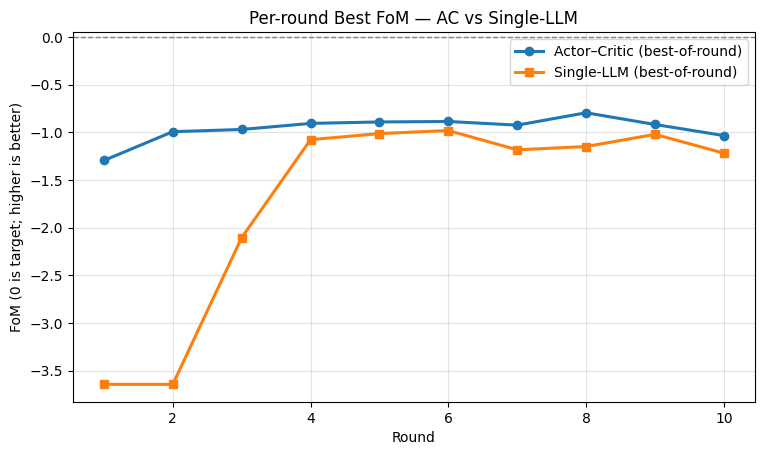

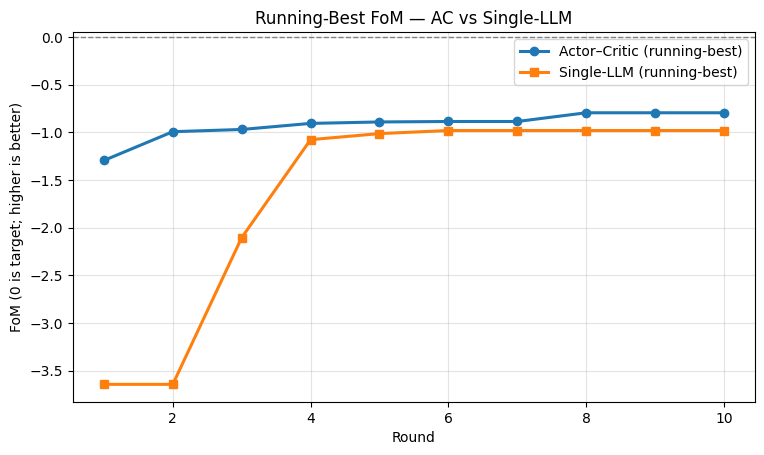

In [55]:
# Step 16 — Per-round best FoM comparison: Actor–Critic vs Single-LLM (robust, no 1e9 flattening)

import numpy as np
import matplotlib.pyplot as plt

def _valid_best(rec):
    return isinstance(rec, dict) and ("fom" in rec) and rec.get("metrics") and rec.get("design")

def _best_of_all(all_list):
    if not all_list:
        return None
    pool = [r for r in all_list if isinstance(r, dict) and ("fom" in r) and r.get("metrics") and r.get("design")]
    return max(pool, key=lambda r: r["fom"]) if pool else None

def _pick_round_best(h):
    # AC history uses "best"; SR history uses "best_round"
    for k in ("best_round","best","best_so_far"):
        if _valid_best(h.get(k)):
            return h[k]
    return _best_of_all(h.get("all"))

def _series_from_history(hist):
    y=[]
    for h in hist:
        br = _pick_round_best(h)
        y.append(br["fom"] if _valid_best(br) else np.nan)
    y = np.asarray(y, dtype=float)
    # Treat absurd sentinels (like -1e9) as missing:
    y[np.isinf(y)] = np.nan
    y[np.abs(y) > 1e3] = np.nan   # FoM should be ~[-5, 0]; anything huge is a sentinel
    return y

# Build robust per-round best arrays
ac_round_foms = _series_from_history(history)
sr_round_foms = _series_from_history(history_sr)

# Determine common length to compare (show up to min rounds; you can also plot full length separately if you prefer)
R = int(min(len(ac_round_foms), len(sr_round_foms)))
x = np.arange(1, R+1)

# Compute sensible y-limits from finite values
finite_vals = np.concatenate([np.atleast_1d(ac_round_foms[:R][np.isfinite(ac_round_foms[:R])]),
                              np.atleast_1d(sr_round_foms[:R][np.isfinite(sr_round_foms[:R])])])
ymin = (np.nanmin(finite_vals) if finite_vals.size else -1.5)
ymax = 0.05  # FoM is capped at 0 by design

# ---- Per-round best (not running-best) ----
plt.figure(figsize=(8.8, 4.8))
plt.plot(x, ac_round_foms[:R], marker="o", linewidth=2.2, label="Actor–Critic (best-of-round)")
plt.plot(x, sr_round_foms[:R], marker="s", linewidth=2.2, label="Single-LLM (best-of-round)")
plt.axhline(0.0, color="gray", lw=1.0, ls="--")
plt.xlabel("Round")
plt.ylabel("FoM (0 is target; higher is better)")
plt.title("Per-round Best FoM — AC vs Single-LLM")
plt.grid(True, alpha=0.35)
plt.legend()

# kill the scientific 1e9 offset on the y-axis
ax = plt.gca()
ax.ticklabel_format(style='plain', useOffset=False, axis='y')
ax.set_ylim(ymin - 0.05*(abs(ymin)+1e-9), ymax)

plt.show()

# ---- Running-best curves (monotonic improvement) ----
def _runbest(y):
    y = np.asarray(y, dtype=float)
    # running max that skips NaNs (forward-fill the last finite max)
    out = np.full_like(y, np.nan)
    cur = -np.inf
    for i, v in enumerate(y):
        if np.isfinite(v):
            cur = max(cur, v)
        out[i] = cur if np.isfinite(cur) else np.nan
    return out

ac_runbest = _runbest(ac_round_foms[:R])
sr_runbest = _runbest(sr_round_foms[:R])

finite_vals_rb = np.concatenate([np.atleast_1d(ac_runbest[np.isfinite(ac_runbest)]),
                                 np.atleast_1d(sr_runbest[np.isfinite(sr_runbest)])])
ymin_rb = (np.nanmin(finite_vals_rb) if finite_vals_rb.size else -1.5)

plt.figure(figsize=(8.8, 4.8))
plt.plot(x, ac_runbest, marker="o", linewidth=2.2, label="Actor–Critic (running-best)")
plt.plot(x, sr_runbest, marker="s", linewidth=2.2, label="Single-LLM (running-best)")
plt.axhline(0.0, color="gray", lw=1.0, ls="--")
plt.xlabel("Round")
plt.ylabel("FoM (0 is target; higher is better)")
plt.title("Running-Best FoM — AC vs Single-LLM")
plt.grid(True, alpha=0.35)
plt.legend()

ax = plt.gca()
ax.ticklabel_format(style='plain', useOffset=False, axis='y')
ax.set_ylim(ymin_rb - 0.05*(abs(ymin_rb)+1e-9), 0.05)

plt.show()


#Recent one after modification to match ledro

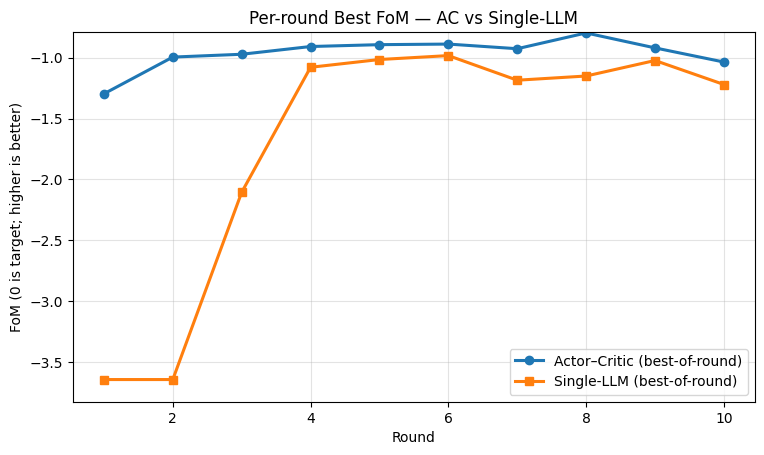

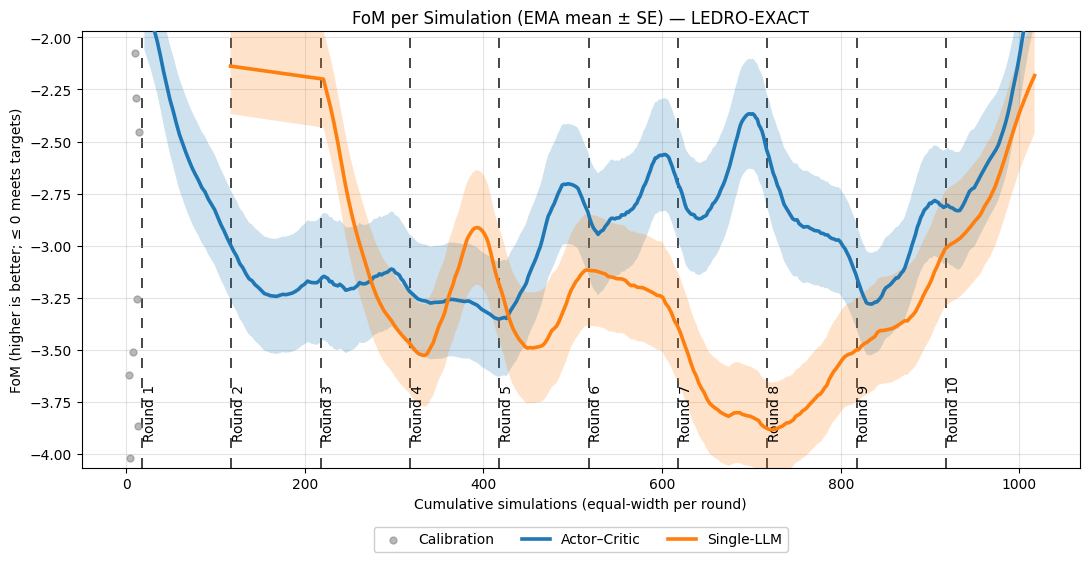

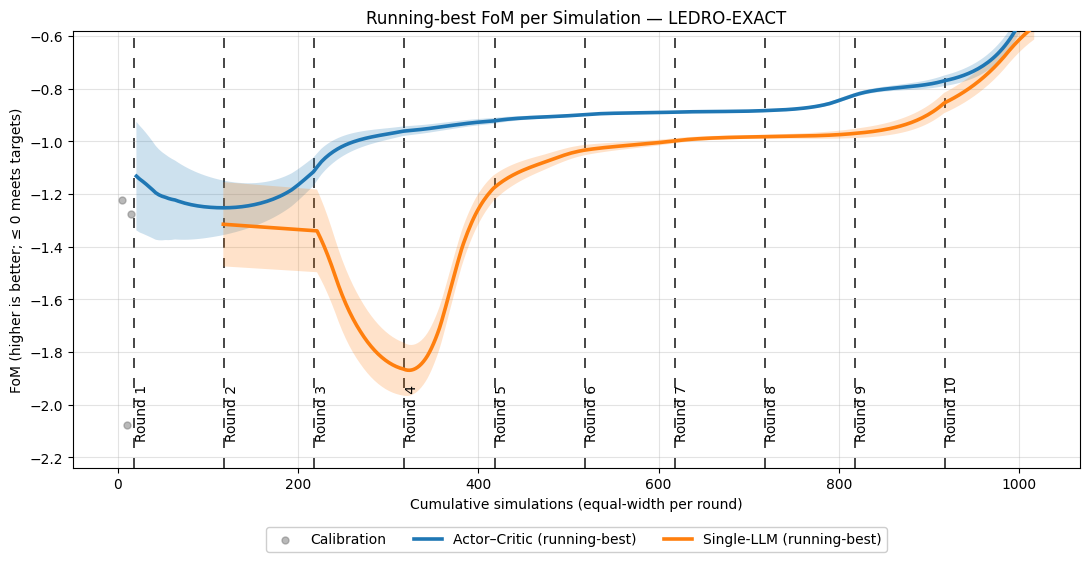

In [58]:
# Step 16 — Per-round & per-simulation FoM comparisons (LEDRO-EXACT, with spacing toggle & smoothing)

import numpy as np
import matplotlib.pyplot as plt

# =============== CONFIG ===============
USE_EQUAL_WIDTH = True   # True => each round drawn with equal horizontal width; False => actual logged count
BLOCK = 100              # visual width per round when equal-spacing is on (LEDRO protocol: 100 samples/round)
PAD_SR_TO_AC = True      # pad Single-LLM to AC x-extent (for continuous orange line)
ALPHA   = 0.07           # EMA smoothing (smaller => smoother; try 0.05–0.10)
MA_K    = 11             # centered moving average window (odd; 9–21 works well)
# ======================================

# ---------- helpers ----------
def traces_from_history(hist):
    """List of arrays, one per round, of per-simulation FoMs (already LEDRO-exact)."""
    if not hist: return []
    return [np.array([rec["fom"] for rec in h["all"]], dtype=float) for h in hist]

def running_best(y):
    y = np.asarray(y, dtype=float)
    if y.size == 0: return y
    return np.maximum.accumulate(y)

def _ema(y, alpha):
    y = np.asarray(y, dtype=float)
    if y.size == 0: return y
    out = np.zeros_like(y)
    m = 0.0; a1 = 1.0 - alpha
    for i, v in enumerate(y):
        m = a1*m + alpha*v
        out[i] = m
    return out

def _ema_twopass(y, alpha):
    if len(y) == 0: return y
    fwd = _ema(y, alpha)
    bwd = _ema(y[::-1], alpha)[::-1]
    return 0.5*(fwd + bwd)

def _movavg(y, k):
    if k <= 1 or len(y) == 0: return y
    k = int(k) | 1  # force odd
    pad = k//2
    ypad = np.pad(y, (pad,pad), mode='edge')
    ker = np.ones(k, dtype=float)/k
    return np.convolve(ypad, ker, mode='valid')

def _ema_mean_se_twopass(y, alpha):
    """Two-pass EMA mean; SE from two-pass EMA of squared residuals (approx)."""
    y = np.asarray(y, float)
    if y.size == 0:
        return np.array([]), np.array([])
    mu = _ema_twopass(y, alpha)
    resid2 = (y - mu)**2
    v = _ema_twopass(resid2, max(alpha*0.7, 1e-3))
    n_eff = max(1.0, 1.0/alpha)
    se = np.sqrt(np.maximum(v, 0.0))/np.sqrt(n_eff)
    return mu, se

def _robust_ylim(*series, pad=0.05, lo_q=2.0, hi_q=98.0):
    vals = np.concatenate([np.asarray(s, float) for s in series if s is not None and len(s)])
    vals = vals[np.isfinite(vals)]
    if vals.size == 0: return (-1.5, 0.05)
    lo = np.nanpercentile(vals, lo_q)
    hi = np.nanpercentile(vals, hi_q)
    hi = min(0.05, hi + pad*abs(hi if hi!=0 else 1.0))  # FoM max is 0
    lo = lo - pad*abs(lo if lo!=0 else 1.0)
    if hi - lo < 0.2: lo = hi - 0.2
    return (lo, hi)

def concat_with_offsets(traces, start):
    xs=[]; off=start
    for t in traces:
        xs.append(off + np.arange(1, len(t)+1))
        off += len(t)
    x_all = np.concatenate(xs) if xs else np.array([], dtype=int)
    y_all = np.concatenate(traces) if traces else np.array([], dtype=float)
    return x_all, y_all

def equal_width_concat(traces, start, block=100):
    xs=[]; off=float(start)
    for t in traces:
        Li = len(t)
        if Li == 0:
            xs.append(np.array([], dtype=float)); off += block; continue
        scale = block / float(Li)
        xi = off + np.arange(1, Li+1, dtype=float) * scale
        xs.append(xi); off += block
    x_all = np.concatenate(xs) if xs else np.array([], dtype=float)
    y_all = np.concatenate(traces) if traces else np.array([], dtype=float)
    return x_all, y_all

def _valid_best(rec):
    return isinstance(rec, dict) and ("fom" in rec) and rec.get("metrics") and rec.get("design")

def _best_of_all(all_list):
    if not all_list: return None
    pool = [r for r in all_list if isinstance(r, dict) and ("fom" in r) and r.get("metrics") and r.get("design")]
    return max(pool, key=lambda r: r["fom"]) if pool else None

def _pick_round_best(h):
    for k in ("best_round","best","best_so_far"):
        if _valid_best(h.get(k)): return h[k]
    return _best_of_all(h.get("all"))

def _series_from_history(hist):
    y=[]
    for h in hist:
        br = _pick_round_best(h)
        y.append(br["fom"] if _valid_best(br) else np.nan)
    y = np.asarray(y, dtype=float)
    y[np.isinf(y)] = np.nan
    y[np.abs(y) > 1e3] = np.nan  # drop absurd sentinels
    return y

# ---------- calibration FoMs ----------
calib_foms = np.array([
    ledro_fom_exact({
        "gain_dB": p["metrics"]["gain_dB"],
        "ugbw_MHz": p["metrics"]["ugbw_MHz"],
        "phase_margin_deg": p["metrics"]["phase_margin_deg"],
        "power_mW": p["metrics"]["power_mW"],
    }, b_exact=BOUND_EXACT, weights=LEDRO_WEIGHTS, vdd=PDK["VDD"])
    for p in CALIB_POOL
], dtype=float)
x_cal, post_cal = np.arange(1, len(calib_foms)+1), len(calib_foms)

# ---------- per-round best (robust) ----------
ac_round_foms = _series_from_history(history)
sr_round_foms = _series_from_history(history_sr) if 'history_sr' in globals() else np.array([])

R = int(min(len(ac_round_foms), len(sr_round_foms))) if sr_round_foms.size else len(ac_round_foms)
x = np.arange(1, R+1)

plt.figure(figsize=(8.8, 4.8))
plt.plot(np.arange(1, len(ac_round_foms)+1), ac_round_foms, marker="o", linewidth=2.2, label="Actor–Critic (best-of-round)")
if sr_round_foms.size:
    plt.plot(np.arange(1, len(sr_round_foms)+1), sr_round_foms, marker="s", linewidth=2.2, label="Single-LLM (best-of-round)")
plt.axhline(0.0, color="gray", lw=1.0, ls="--")
plt.xlabel("Round"); plt.ylabel("FoM (0 is target; higher is better)")
plt.title("Per-round Best FoM — AC vs Single-LLM"); plt.grid(True, alpha=0.35); plt.legend()

ax = plt.gca()
ax.ticklabel_format(style='plain', useOffset=False, axis='y')
ymin, ymax = _robust_ylim(ac_round_foms, sr_round_foms)
ax.set_ylim(ymin, ymax)
plt.show()

# ---------- per-simulation EMA mean ± SE (with spacing toggle) ----------
ac_trs = traces_from_history(history)
sr_trs = traces_from_history(history_sr) if 'history_sr' in globals() else []

if USE_EQUAL_WIDTH:
    x_ac_all, y_ac_all = equal_width_concat(ac_trs, post_cal, block=BLOCK)
    x_sr_all, y_sr_all = equal_width_concat(sr_trs, post_cal, block=BLOCK)
    round_x = [post_cal + i*BLOCK + 1 for i in range(len(ac_trs))]
else:
    x_ac_all, y_ac_all = concat_with_offsets(ac_trs, post_cal)
    x_sr_all, y_sr_all = concat_with_offsets(sr_trs, post_cal)
    round_x = []
    cum = post_cal
    for t in ac_trs:
        round_x.append(cum + 1); cum += len(t)

# If SR ended earlier, extend its line to AC extent so both reach the same x
if PAD_SR_TO_AC and x_sr_all.size and x_ac_all.size and (x_sr_all[-1] < x_ac_all[-1]):
    last_x = x_sr_all[-1]; last_y = y_sr_all[-1]
    x_extra = np.arange(last_x + (1 if USE_EQUAL_WIDTH else 1), x_ac_all[-1] + 1)
    if x_extra.size > 0:
        y_extra = np.full_like(x_extra, last_y, dtype=float)
        x_sr_all = np.concatenate([x_sr_all, x_extra])
        y_sr_all = np.concatenate([y_sr_all, y_extra])

mu_ac_raw, se_ac_raw = _ema_mean_se_twopass(y_ac_all, ALPHA) if x_ac_all.size else (np.array([]), np.array([]))
mu_sr_raw, se_sr_raw = _ema_mean_se_twopass(y_sr_all, ALPHA) if x_sr_all.size else (np.array([]), np.array([]))

mu_ac = _movavg(mu_ac_raw, MA_K); se_ac = _movavg(se_ac_raw, MA_K)
mu_sr = _movavg(mu_sr_raw, MA_K); se_sr = _movavg(se_sr_raw, MA_K)

fig, ax = plt.subplots(figsize=(11,6))
ax.scatter(x_cal, calib_foms, s=25, alpha=0.55, color="#808080", label="Calibration", zorder=1)
if x_ac_all.size:
    ax.plot(x_ac_all, mu_ac, lw=2.6, label="Actor–Critic", zorder=4)
    ax.fill_between(x_ac_all, mu_ac - se_ac, mu_ac + se_ac, alpha=0.22, linewidth=0, zorder=2)
if x_sr_all.size:
    ax.plot(x_sr_all, mu_sr, lw=2.6, label="Single-LLM", zorder=4)
    ax.fill_between(x_sr_all, mu_sr - se_sr, mu_sr + se_sr, alpha=0.22, linewidth=0, zorder=2)

vls = (0, (6,6))
for i, rx in enumerate(round_x, 1):
    ax.axvline(x=rx, color="black", linestyle=vls, lw=1.2, alpha=0.85, zorder=0)
    ax.text(rx + 0.5, 0.06, f"Round {i}", rotation=90, va="bottom", ha="left",
            transform=ax.get_xaxis_transform(), fontsize=10, color="black")

ax.axhline(0.0, ls=":", color="gray", lw=1.2, alpha=0.9)
ax.set_title("FoM per Simulation (EMA mean ± SE) — LEDRO-EXACT")
ax.set_xlabel("Cumulative simulations" if not USE_EQUAL_WIDTH else "Cumulative simulations (equal-width per round)")
ax.set_ylabel("FoM (higher is better; ≤ 0 meets targets)")
ax.grid(True, alpha=0.35)

ylim_lo, ylim_hi = _robust_ylim(mu_ac, mu_sr, calib_foms, lo_q=2.0, hi_q=98.0)
ax.set_ylim(ylim_lo, ylim_hi)
ax.ticklabel_format(style='plain', useOffset=False, axis='y')
ax.legend(loc="upper center", ncol=3, frameon=True, framealpha=0.95, bbox_to_anchor=(0.5, -0.12))
fig.tight_layout(rect=[0, 0.04, 1, 1])
plt.show()

# ---------- running-best per-simulation (smoothed) ----------
y_ac_best = running_best(y_ac_all)
y_sr_best = running_best(y_sr_all) if x_sr_all.size else np.array([])

mu_ac_rb_raw, se_ac_rb_raw = _ema_mean_se_twopass(y_ac_best, ALPHA) if x_ac_all.size else (np.array([]), np.array([]))
mu_sr_rb_raw, se_sr_rb_raw = _ema_mean_se_twopass(y_sr_best, ALPHA) if x_sr_all.size else (np.array([]), np.array([]))

mu_ac_rb = _movavg(mu_ac_rb_raw, MA_K); se_ac_rb = _movavg(se_ac_rb_raw, MA_K)
mu_sr_rb = _movavg(mu_sr_rb_raw, MA_K); se_sr_rb = _movavg(se_sr_rb_raw, MA_K)

fig, ax = plt.subplots(figsize=(11,6))
ax.scatter(x_cal, calib_foms, s=25, alpha=0.55, color="#808080", label="Calibration", zorder=1)
if x_ac_all.size:
    ax.plot(x_ac_all, mu_ac_rb, lw=2.6, label="Actor–Critic (running-best)", zorder=4)
    ax.fill_between(x_ac_all, mu_ac_rb - se_ac_rb, mu_ac_rb + se_ac_rb, alpha=0.22, linewidth=0, zorder=2)
if x_sr_all.size:
    ax.plot(x_sr_all, mu_sr_rb, lw=2.6, label="Single-LLM (running-best)", zorder=4)
    ax.fill_between(x_sr_all, mu_sr_rb - se_sr_rb, mu_sr_rb + se_sr_rb, alpha=0.22, linewidth=0, zorder=2)

for i, rx in enumerate(round_x, 1):
    ax.axvline(x=rx, color="black", linestyle=vls, lw=1.2, alpha=0.85, zorder=0)
    ax.text(rx + 0.5, 0.06, f"Round {i}", rotation=90, va="bottom", ha="left",
            transform=ax.get_xaxis_transform(), fontsize=10, color="black")

ax.axhline(0.0, ls=":", color="gray", lw=1.2, alpha=0.9)
ax.set_title("Running-best FoM per Simulation — LEDRO-EXACT")
ax.set_xlabel("Cumulative simulations" if not USE_EQUAL_WIDTH else "Cumulative simulations (equal-width per round)")
ax.set_ylabel("FoM (higher is better; ≤ 0 meets targets)")
ax.grid(True, alpha=0.35)

ylim_lo_rb, ylim_hi_rb = _robust_ylim(mu_ac_rb, mu_sr_rb, calib_foms, lo_q=2.0, hi_q=98.0)
ax.set_ylim(ylim_lo_rb, ylim_hi_rb)
ax.ticklabel_format(style='plain', useOffset=False, axis='y')
ax.legend(loc="upper center", ncol=3, frameon=True, framealpha=0.95, bbox_to_anchor=(0.5, -0.12))
fig.tight_layout(rect=[0, 0.04, 1, 1])
plt.show()


In [54]:
# Final plot — EMA mean with SE shading (AC vs Single-LLM)
import numpy as np
import matplotlib.pyplot as plt

def traces_from_history(hist):
    return [np.array([rec["fom"] for rec in h["all"]]) for h in hist]

def ewm_mean_se(y, alpha=0.15):
    y = np.asarray(y, dtype=float)
    n = len(y)
    mu, var, se = np.zeros(n), np.zeros(n), np.zeros(n)
    mu_prev = var_prev = 0.0
    sum_w = sum_w2 = 0.0
    one_ma = 1.0 - alpha
    for t in range(n):
        x = y[t]
        sum_w  = one_ma * sum_w  + alpha
        sum_w2 = (one_ma**2) * sum_w2 + alpha**2
        mu_t   = one_ma * mu_prev + alpha * x
        var_t  = one_ma * (var_prev + alpha * (x - mu_prev)**2)
        n_eff  = (sum_w**2) / max(sum_w2, 1.0)
        mu[t], var[t] = mu_t, var_t
        se[t]  = np.sqrt(max(var_t, 0.0)) / np.sqrt(max(n_eff, 1.0))
        mu_prev, var_prev = mu_t, var_t
    return mu, se

cal_color = "#808080"
ac_line   = "#003366"
sr_line   = "#B22222"
ac_fill   = "#3A8DFF"
sr_fill   = "#FF7F7F"

calib_foms = np.array([ledro_fom({"gain_dB":p["metrics"]["gain_dB"],
                                  "ugbw_MHz":p["metrics"]["ugbw_MHz"],
                                  "phase_margin_deg":clamp_pm_for_scoring(p["metrics"]["phase_margin_deg"]),
                                  "power_mW":p["metrics"]["power_mW"]}, b=BOUND) for p in CALIB_POOL])
x_cal, post_cal = np.arange(1, len(calib_foms)+1), len(calib_foms)
ac_trs, sr_trs = traces_from_history(history), traces_from_history(history_sr)

x_ac, x_sr = [], []
off = post_cal
for t in ac_trs:
    xa = off + np.arange(1, len(t)+1)
    x_ac.append(xa)
    off += len(t)
off = post_cal
for t in sr_trs:
    xs = off + np.arange(1, len(t)+1)
    x_sr.append(xs)
    off += len(t)

x_ac_all = np.concatenate(x_ac) if x_ac else np.array([])
y_ac_all = np.concatenate(ac_trs) if ac_trs else np.array([])
x_sr_all = np.concatenate(x_sr) if x_sr else np.array([])
y_sr_all = np.concatenate(sr_trs) if sr_trs else np.array([])

alpha = 0.15
mu_ac, se_ac = ewm_mean_se(y_ac_all, alpha) if len(y_ac_all) else ([], [])
mu_sr, se_sr = ewm_mean_se(y_sr_all, alpha) if len(y_sr_all) else ([], [])

round_x = []
cum = post_cal
for t in ac_trs:
    round_x.append(cum + 1)
    cum += len(t)

fig, ax = plt.subplots(figsize=(11,6))
ax.scatter(x_cal, calib_foms, s=25, alpha=0.55, color=cal_color, label="Calibration", zorder=1)
if len(x_ac_all):
    ax.plot(x_ac_all, mu_ac, color=ac_line, lw=2.8, label="Actor–Critic", zorder=4)
    ax.fill_between(x_ac_all, mu_ac - se_ac, mu_ac + se_ac, color=ac_fill, alpha=0.25, linewidth=0, zorder=2)
if len(x_sr_all):
    ax.plot(x_sr_all, mu_sr, color=sr_line, lw=2.8, label="Single-LLM", zorder=4)
    ax.fill_between(x_sr_all, mu_sr - se_sr, mu_sr + se_sr, color=sr_fill, alpha=0.25, linewidth=0, zorder=2)

vls = (0, (6,6))
for i, rx in enumerate(round_x, 1):
    ax.axvline(x=rx, color="black", linestyle=vls, lw=1.4, alpha=0.8, zorder=0)
    ax.text(rx + 0.5, 0.06, f"Round {i}", rotation=90, va="bottom", ha="left",
            transform=ax.get_xaxis_transform(), fontsize=11, color="black")

ax.axhline(0.0, ls=":", color="gray", lw=1.4, alpha=0.9)
ax.set_title("FoM per Simulation (SKY130 OTA via ngspice)", fontsize=20, pad=14)
ax.set_xlabel("Cumulative simulations", fontsize=16)
ax.set_ylabel("FoM (higher is better; ≤ 0 meets cushioned targets)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True, alpha=0.35)

handles, labels = ax.get_legend_handles_labels()
keep = {"Calibration", "Actor–Critic", "Single-LLM"}
h_final, l_final, seen = [], [], set()
for h, l in zip(handles, labels):
    if l in keep and l not in seen:
        seen.add(l); h_final.append(h); l_final.append(l)
ax.legend(h_final, l_final, fontsize=12, frameon=True, loc="upper center",
          fancybox=True, framealpha=0.95, ncol=3, handletextpad=1.0, bbox_to_anchor=(0.5, -0.12))

fig.tight_layout(rect=[0, 0.04, 1, 1])
plt.show()


TypeError: ledro_fom() got an unexpected keyword argument 'b'

In [ ]:
# Final plot — Running-best FoM with EMA smoothing (AC vs Single-LLM)
import numpy as np
import matplotlib.pyplot as plt

def traces_from_history(hist):
    return [np.array([rec["fom"] for rec in h["all"]]) for h in hist]

def ewm_mean_se(y, alpha=0.15):
    y = np.asarray(y, dtype=float)
    n = len(y)
    mu, var, se = np.zeros(n), np.zeros(n), np.zeros(n)
    mu_prev = var_prev = 0.0
    sum_w = sum_w2 = 0.0
    one_ma = 1.0 - alpha
    for t in range(n):
        x = y[t]
        sum_w  = one_ma * sum_w  + alpha
        sum_w2 = (one_ma**2) * sum_w2 + alpha**2
        mu_t   = one_ma * mu_prev + alpha * x
        var_t  = one_ma * (var_prev + alpha * (x - mu_prev)**2)
        n_eff  = (sum_w**2) / max(sum_w2, 1.0e-12)
        mu[t], var[t] = mu_t, var_t
        se[t]  = np.sqrt(max(var_t, 0.0)) / np.sqrt(max(n_eff, 1.0))
        mu_prev, var_prev = mu_t, var_t
    return mu, se

def running_best(y):
    y = np.asarray(y, dtype=float)
    if y.size == 0:
        return y
    return np.maximum.accumulate(y)

# Colors / styles
cal_color = "#808080"
ac_line   = "#003366"  # Actor–Critic (blue)
sr_line   = "#B22222"  # Single-LLM (red)
ac_fill   = "#3A8DFF"
sr_fill   = "#FF7F7F"

# Calibration FoMs
calib_foms = np.array([
    ledro_fom({
        "gain_dB": p["metrics"]["gain_dB"],
        "ugbw_MHz": p["metrics"]["ugbw_MHz"],
        "phase_margin_deg": clamp_pm_for_scoring(p["metrics"]["phase_margin_deg"]),
        "power_mW": p["metrics"]["power_mW"]
    }, b=BOUND) for p in CALIB_POOL
])
x_cal, post_cal = np.arange(1, len(calib_foms)+1), len(calib_foms)

# Per-simulation FoMs (all evaluations) pulled from history
ac_trs, sr_trs = traces_from_history(history), traces_from_history(history_sr)

# Build x-axes that continue after calibration
x_ac, x_sr = [], []
off = post_cal
for t in ac_trs:
    xa = off + np.arange(1, len(t)+1)
    x_ac.append(xa)
    off += len(t)
off = post_cal
for t in sr_trs:
    xs = off + np.arange(1, len(t)+1)
    x_sr.append(xs)
    off += len(t)

# Flatten
x_ac_all = np.concatenate(x_ac) if x_ac else np.array([])
y_ac_all = np.concatenate(ac_trs) if ac_trs else np.array([])
x_sr_all = np.concatenate(x_sr) if x_sr else np.array([])
y_sr_all = np.concatenate(sr_trs) if sr_trs else np.array([])

# Use running-best before smoothing
alpha = 0.15
y_ac_all_best = running_best(y_ac_all)
y_sr_all_best = running_best(y_sr_all)

mu_ac, se_ac = ewm_mean_se(y_ac_all_best, alpha) if len(y_ac_all_best) else ([], [])
mu_sr, se_sr = ewm_mean_se(y_sr_all_best, alpha) if len(y_sr_all_best) else ([], [])

# Round markers based on AC round boundaries
round_x = []
cum = post_cal
for t in ac_trs:
    round_x.append(cum + 1)
    cum += len(t)

# Plot
fig, ax = plt.subplots(figsize=(11,6))
ax.scatter(x_cal, calib_foms, s=25, alpha=0.55, color=cal_color, label="Calibration", zorder=1)

if len(x_ac_all):
    ax.plot(x_ac_all, mu_ac, color=ac_line, lw=2.8, label="Actor–Critic", zorder=4)
    ax.fill_between(x_ac_all, mu_ac - se_ac, mu_ac + se_ac, color=ac_fill, alpha=0.25, linewidth=0, zorder=2)
if len(x_sr_all):
    ax.plot(x_sr_all, mu_sr, color=sr_line, lw=2.8, label="Single-LLM", zorder=4)
    ax.fill_between(x_sr_all, mu_sr - se_sr, mu_sr + se_sr, color=sr_fill, alpha=0.25, linewidth=0, zorder=2)

vls = (0, (6,6))
for i, rx in enumerate(round_x, 1):
    ax.axvline(x=rx, color="black", linestyle=vls, lw=1.4, alpha=0.8, zorder=0)
    ax.text(rx + 0.5, 0.06, f"Round {i}", rotation=90, va="bottom", ha="left",
            transform=ax.get_xaxis_transform(), fontsize=11, color="black")

ax.axhline(0.0, ls=":", color="gray", lw=1.4, alpha=0.9)
ax.set_title("Running-best FoM per Simulation (SKY130 OTA via ngspice)", fontsize=20, pad=14)
ax.set_xlabel("Cumulative simulations", fontsize=16)
ax.set_ylabel("FoM (higher is better; ≤ 0 meets cushioned targets)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True, alpha=0.35)

handles, labels = ax.get_legend_handles_labels()
keep = {"Calibration", "Actor–Critic", "Single-LLM"}
h_final, l_final, seen = [], [], set()
for h, l in zip(handles, labels):
    if l in keep and l not in seen:
        seen.add(l); h_final.append(h); l_final.append(l)
ax.legend(h_final, l_final, fontsize=12, frameon=True, loc="upper center",
          fancybox=True, framealpha=0.95, ncol=3, handletextpad=1.0, bbox_to_anchor=(0.5, -0.12))

fig.tight_layout(rect=[0, 0.04, 1, 1])
plt.show()


In [ ]:
# Final plot — Equal budgets + Auto-zoom to show separation clearly

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# ---------- helpers ----------
def ewm_mean_se(y, alpha=0.12):
    y = np.asarray(y, dtype=float)
    n = len(y)
    if n == 0:
        return np.array([]), np.array([])
    mu, var, se = np.zeros(n), np.zeros(n), np.zeros(n)
    mu_prev = var_prev = 0.0
    sum_w = sum_w2 = 0.0
    one = 1.0 - alpha
    for t in range(n):
        x = y[t]
        sum_w  = one * sum_w  + alpha
        sum_w2 = (one**2) * sum_w2 + alpha**2
        mu_t   = one * mu_prev + alpha * x
        var_t  = one * (var_prev + alpha * (x - mu_prev)**2)
        n_eff  = (sum_w**2) / max(sum_w2, 1e-12)
        mu[t], var[t] = mu_t, var_t
        se[t]  = np.sqrt(max(var_t, 0.0)) / np.sqrt(max(n_eff, 1.0))
        mu_prev, var_prev = mu_t, var_t
    return mu, se

def running_best(y):
    y = np.asarray(y, dtype=float)
    return np.maximum.accumulate(y) if y.size else y

def equalize_per_round(ac_hist, sr_hist, budget=None, max_rounds=None):
    R = min(len(ac_hist), len(sr_hist)) if max_rounds is None else min(len(ac_hist), len(sr_hist), max_rounds)
    ac_eq, sr_eq, counts = [], [], []
    for r in range(R):
        a = np.array([rec["fom"] for rec in ac_hist[r]["all"]], float)
        s = np.array([rec["fom"] for rec in sr_hist[r]["all"]], float)
        m = budget if budget is not None else min(len(a), len(s))
        if m <= 0: continue
        ac_eq.append(a[:m]); sr_eq.append(s[:m]); counts.append(m)
    return ac_eq, sr_eq, counts

# ---------- styles ----------
cal_color = "#808080"
ac_line   = "#003366"
sr_line   = "#B22222"
ac_fill   = "#3A8DFF"
sr_fill   = "#FF7F7F"

# ---------- calibration FoMs ----------
calib_foms = np.array([
    ledro_fom({
        "gain_dB": p["metrics"]["gain_dB"],
        "ugbw_MHz": p["metrics"]["ugbw_MHz"],
        "phase_margin_deg": clamp_pm_for_scoring(p["metrics"]["phase_margin_deg"]),
        "power_mW": p["metrics"]["power_mW"]
    }, b=BOUND)
    for p in CALIB_POOL
], float)
x_cal, post_cal = np.arange(1, len(calib_foms)+1), len(calib_foms)

# ---------- equalize budgets per round ----------
BUDGET = None     # or set to an int (e.g., 10) to force that many sims per round
MAX_ROUNDS = None
ac_trs, sr_trs, counts = equalize_per_round(history, history_sr, budget=BUDGET, max_rounds=MAX_ROUNDS)

# ---------- shared cumulative x and round markers ----------
x_all = np.array([], int)
round_x = []
cum = post_cal
for m in counts:
    round_x.append(cum + 1)
    x_all = np.concatenate([x_all, cum + np.arange(1, m+1)])
    cum += m

# ---------- flatten, running-best, smooth ----------
y_ac = np.concatenate(ac_trs) if ac_trs else np.array([])
y_sr = np.concatenate(sr_trs) if sr_trs else np.array([])
alpha = 0.12
y_ac_best = running_best(y_ac)
y_sr_best = running_best(y_sr)
mu_ac, se_ac = ewm_mean_se(y_ac_best, alpha) if y_ac_best.size else (np.array([]), np.array([]))
mu_sr, se_sr = ewm_mean_se(y_sr_best, alpha) if y_sr_best.size else (np.array([]), np.array([]))

# ---------- AUTO-ZOOM logic ----------
# We zoom the main y-axis to the envelope of the two smoothed curves
# (ignoring calibration points), so the separation is visible.
def compute_zoom_limits(a, b, pad_min=0.003, pad_frac=0.2):
    lo = float(min(a.min(), b.min()))
    hi = float(max(a.max(), b.max()))
    span = max(hi - lo, 1e-6)
    pad = max(pad_min, pad_frac * span)
    return lo - pad, hi + pad

# Optional: focus only on the last N points where curves usually converge
FOCUS_LAST_N = 0   # set >0 to zoom on the final window (e.g., 30)
if FOCUS_LAST_N > 0 and len(mu_ac) > FOCUS_LAST_N and len(mu_sr) > FOCUS_LAST_N:
    sl = slice(-FOCUS_LAST_N, None)
    zoom_lo, zoom_hi = compute_zoom_limits(mu_ac[sl], mu_sr[sl])
else:
    zoom_lo, zoom_hi = compute_zoom_limits(mu_ac, mu_sr)

# ---------- ΔFoM (and optional scaling for readability) ----------
gap = (mu_ac - mu_sr) if mu_ac.size and mu_sr.size else np.array([])
GAP_SCALE = 1.0      # set to 1000.0 to show ΔFoM in milli-FoM
gap_plot = gap * GAP_SCALE

# ΔFoM y-limits: symmetric tight bounds around zero
if gap_plot.size:
    g_absmax = float(np.max(np.abs(gap_plot)))
    g_pad = 0.08 * g_absmax if g_absmax > 0 else 0.01
    gap_lo, gap_hi = -g_absmax - g_pad, g_absmax + g_pad
else:
    gap_lo, gap_hi = -0.01, 0.01

# ---------- figure ----------
fig = plt.figure(figsize=(11, 7.2), constrained_layout=True)
gs  = GridSpec(2, 1, height_ratios=[3.7, 1.1], figure=fig, hspace=0.18)
ax  = fig.add_subplot(gs[0])
axg = fig.add_subplot(gs[1], sharex=ax)

# Calibration scatter (kept, but will sit outside zoomed y-range)
ax.scatter(x_cal, calib_foms, s=22, alpha=0.45, color=cal_color, label="Calibration", zorder=1)

# Main curves
if x_all.size:
    ax.plot(x_all, mu_ac, drawstyle="steps-post", color=ac_line, lw=3.0, label="Actor–Critic", zorder=5)
    ax.plot(x_all, mu_sr, drawstyle="steps-post", color=sr_line, lw=2.8, label="Single-LLM",  zorder=4)
    ax.fill_between(x_all, mu_ac - se_ac, mu_ac + se_ac, color=ac_fill, alpha=0.12, linewidth=0, zorder=2)
    ax.fill_between(x_all, mu_sr - se_sr, mu_sr + se_sr, color=sr_fill, alpha=0.12, linewidth=0, zorder=1)

    # Gap ribbon (blue where AC>SR, red where SR>AC)
    above = gap > 0
    below = gap < 0
    ax.fill_between(x_all, mu_sr, mu_ac, where=above, step="post", interpolate=True,
                    color=ac_fill, alpha=0.20, linewidth=0, zorder=3)
    ax.fill_between(x_all, mu_sr, mu_ac, where=below, step="post", interpolate=True,
                    color=sr_fill, alpha=0.20, linewidth=0, zorder=3)

# Round separators
vls = (0, (6, 6))
for i, rx in enumerate(round_x, 1):
    ax.axvline(x=rx, color="black", linestyle=vls, lw=1.2, alpha=0.8, zorder=0)
    ax.text(rx + 0.5, zoom_hi, f"Round {i}", rotation=90, va="top", ha="left",
            fontsize=10, color="black")

# Main cosmetics + **auto-zoomed y-limits**
ax.axhline(0.0, ls=":", color="gray", lw=1.2, alpha=0.9)
ax.set_ylim(zoom_lo, zoom_hi)   # <<< zoom so separation is visible
ax.set_title("Running-best FoM per Simulation (SKY130 OTA via ngspice)", fontsize=20, pad=10)
ax.set_ylabel("FoM (higher is better; ≤ 0 meets targets)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True, alpha=0.30)

# Legend
handles, labels = ax.get_legend_handles_labels()
keep = {"Calibration", "Actor–Critic", "Single-LLM"}
h_final, l_final, seen = [], [], set()
for h, l in zip(handles, labels):
    if l in keep and l not in seen:
        seen.add(l); h_final.append(h); l_final.append(l)
ax.legend(h_final, l_final, fontsize=12, frameon=True, loc="upper left",
          fancybox=True, framealpha=0.95, ncol=1, handletextpad=1.0)

# ΔFoM subplot
axg.axhline(0.0, color="gray", lw=1.0, ls="--")
if x_all.size and gap_plot.size:
    axg.plot(x_all, gap_plot, drawstyle="steps-post", color="#2F6CFF", lw=1.8)
    axg.fill_between(x_all, 0, gap_plot, where=(gap_plot>0), step="post", color=ac_fill, alpha=0.25)
    axg.fill_between(x_all, 0, gap_plot, where=(gap_plot<0), step="post", color=sr_fill, alpha=0.25)
axg.set_ylim(gap_lo, gap_hi)   # <<< tight symmetric scaling
ylabel = "ΔFoM" if GAP_SCALE == 1.0 else f"ΔFoM (×{int(GAP_SCALE)})"
axg.set_ylabel(ylabel, fontsize=12)
axg.set_xlabel("Cumulative simulations", fontsize=16)
axg.grid(True, alpha=0.25)
axg.tick_params(axis='both', labelsize=11)

plt.show()


In [ ]:
# Final plot — Right-zoomed on last N sims, calibration hidden, ΔFoM auto-scaled

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# ---------------- config ----------------
SHOW_CAL = False          # hide calibration points entirely
FOCUS_RIGHT_LAST = 30     # focus window: last N simulations on the right
ALPHA_SMOOTH = 0.12       # EMA smoothing for running-best
HEIGHT_RATIOS = [3.2, 1.4]

# ---------- helpers ----------
def ewm_mean_se(y, alpha=0.12):
    y = np.asarray(y, dtype=float)
    n = len(y)
    if n == 0:
        return np.array([]), np.array([])
    mu, var, se = np.zeros(n), np.zeros(n), np.zeros(n)
    mu_prev = var_prev = 0.0
    sum_w = sum_w2 = 0.0
    one = 1.0 - alpha
    for t in range(n):
        x = y[t]
        sum_w  = one * sum_w  + alpha
        sum_w2 = (one**2) * sum_w2 + alpha**2
        mu_t   = one * mu_prev + alpha * x
        var_t  = one * (var_prev + alpha * (x - mu_prev)**2)
        n_eff  = (sum_w**2) / max(sum_w2, 1e-12)
        mu[t], var[t] = mu_t, var_t
        se[t]  = np.sqrt(max(var_t, 0.0)) / np.sqrt(max(n_eff, 1.0))
        mu_prev, var_prev = mu_t, var_t
    return mu, se

def running_best(y):
    y = np.asarray(y, dtype=float)
    return np.maximum.accumulate(y) if y.size else y

def equalize_per_round(ac_hist, sr_hist, budget=None, max_rounds=None):
    R = min(len(ac_hist), len(sr_hist)) if max_rounds is None else min(len(ac_hist), len(sr_hist), max_rounds)
    ac_eq, sr_eq, counts = [], [], []
    for r in range(R):
        a = np.array([rec["fom"] for rec in ac_hist[r]["all"]], float)
        s = np.array([rec["fom"] for rec in sr_hist[r]["all"]], float)
        m = budget if budget is not None else min(len(a), len(s))
        if m <= 0:
            continue
        ac_eq.append(a[:m]); sr_eq.append(s[:m]); counts.append(m)
    return ac_eq, sr_eq, counts

def compute_zoom_limits(a, b, pad_min=0.003, pad_frac=0.25):
    lo = float(min(a.min(), b.min()))
    hi = float(max(a.max(), b.max()))
    span = max(hi - lo, 1e-6)
    pad = max(pad_min, pad_frac * span)
    return lo - pad, hi + pad

# ---------- styles ----------
ac_line   = "#003366"
sr_line   = "#B22222"
ac_fill   = "#3A8DFF"
sr_fill   = "#FF7F7F"

# ============================================================
# Equalize per-round budgets (requires: history, history_sr)
# ============================================================
BUDGET = None
MAX_ROUNDS = None
ac_trs, sr_trs, counts = equalize_per_round(history, history_sr, budget=BUDGET, max_rounds=MAX_ROUNDS)

# ---------- build cumulative x for all sims ----------
post_cal = 0  # no calibration points on the left
x_all = np.array([], int)
round_x = []
cum = post_cal
for m in counts:
    round_x.append(cum + 1)
    x_all = np.concatenate([x_all, cum + np.arange(1, m + 1)])
    cum += m

# ---------- flatten, running-best, smooth ----------
y_ac = np.concatenate(ac_trs) if ac_trs else np.array([])
y_sr = np.concatenate(sr_trs) if sr_trs else np.array([])
y_ac_best = running_best(y_ac)
y_sr_best = running_best(y_sr)
mu_ac, se_ac = ewm_mean_se(y_ac_best, ALPHA_SMOOTH) if y_ac_best.size else (np.array([]), np.array([]))
mu_sr, se_sr = ewm_mean_se(y_sr_best, ALPHA_SMOOTH) if y_sr_best.size else (np.array([]), np.array([]))

# ---------- RIGHT-FOCUS window on last N points ----------
if x_all.size:
    last_n = min(FOCUS_RIGHT_LAST, x_all.size)
    sl = slice(-last_n, None)  # last N points
    x_focus = x_all[sl]
    mu_ac_f, mu_sr_f = mu_ac[sl], mu_sr[sl]
    se_ac_f, se_sr_f = se_ac[sl], se_sr[sl]
else:
    x_focus = np.array([], int)
    mu_ac_f = mu_sr_f = se_ac_f = se_sr_f = np.array([])

# y-limits computed ONLY from focused region so small gaps pop out
if mu_ac_f.size and mu_sr_f.size:
    zoom_lo, zoom_hi = compute_zoom_limits(mu_ac_f, mu_sr_f)
else:
    zoom_lo, zoom_hi = -0.02, 0.01  # fallback

# ---------- ΔFoM (auto-scale: if tiny, show milli-FoM) ----------
gap = (mu_ac - mu_sr) if mu_ac.size and mu_sr.size else np.array([])
gap_f = (mu_ac_f - mu_sr_f) if mu_ac_f.size and mu_sr_f.size else np.array([])
absmax = float(np.max(np.abs(gap_f))) if gap_f.size else 0.0
GAP_SCALE = 1000.0 if absmax > 0 and absmax < 0.002 else 1.0
gap_plot = gap * GAP_SCALE
gap_plot_f = gap_f * GAP_SCALE

if gap_plot_f.size:
    g_absmax = float(np.max(np.abs(gap_plot_f)))
    g_pad = 0.12 * g_absmax if g_absmax > 0 else 0.01
    gap_lo, gap_hi = -g_absmax - g_pad, g_absmax + g_pad
else:
    gap_lo, gap_hi = -0.01, 0.01

# ---------- figure ----------
fig = plt.figure(figsize=(11, 7.2), constrained_layout=True)
gs  = GridSpec(2, 1, height_ratios=HEIGHT_RATIOS, figure=fig, hspace=0.16)
ax  = fig.add_subplot(gs[0])
axg = fig.add_subplot(gs[1], sharex=ax)

# Main curves (focus region will be shown via x-limits)
if x_all.size:
    ax.plot(x_all, mu_ac, drawstyle="steps-post", color=ac_line, lw=3.0, label="Actor–Critic", zorder=4)
    ax.plot(x_all, mu_sr, drawstyle="steps-post", color=sr_line, lw=2.8, label="Single-LLM",  zorder=3)
    ax.fill_between(x_all, mu_ac - se_ac, mu_ac + se_ac, color=ac_fill, alpha=0.14, linewidth=0, zorder=2)
    ax.fill_between(x_all, mu_sr - se_sr, mu_sr + se_sr, color=sr_fill, alpha=0.14, linewidth=0, zorder=1)

    # Gap ribbon for focus region (blue where AC>SR, red where SR>AC)
    if gap_f.size:
        above = gap_f > 0
        below = gap_f < 0
        ax.fill_between(x_focus, mu_sr_f, mu_ac_f, where=above, step="post", interpolate=True,
                        color=ac_fill, alpha=0.25, linewidth=0, zorder=2)
        ax.fill_between(x_focus, mu_sr_f, mu_ac_f, where=below, step="post", interpolate=True,
                        color=sr_fill, alpha=0.25, linewidth=0, zorder=2)

# Round separators (draw only if the line falls inside the x-range)
vls = (0, (6, 6))
for i, rx in enumerate(round_x, 1):
    if x_all.size and (x_all[-1] - FOCUS_RIGHT_LAST + 1) <= rx <= x_all[-1] + 1:
        ax.axvline(x=rx, color="black", linestyle=vls, lw=1.1, alpha=0.9, zorder=0)
        ax.text(rx + 0.3, zoom_hi, f"Round {i}", rotation=90, va="top", ha="left",
                fontsize=10, color="black")

# Cosmetics + right zoom
ax.axhline(0.0, ls=":", color="gray", lw=1.2, alpha=0.9)
ax.set_ylim(zoom_lo, zoom_hi)
if x_all.size:
    x_right = int(x_all[-1])
    x_left  = max(0.5, x_right - FOCUS_RIGHT_LAST + 0.5)
    ax.set_xlim(x_left, x_right + 0.5)
else:
    ax.set_xlim(0.5, 5.5)

ax.set_title("Running-best FoM per Simulation (SKY130 OTA via ngspice)", fontsize=20, pad=10)
ax.set_ylabel("FoM (higher is better; ≤ 0 meets targets)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True, alpha=0.30)

# Legend
ax.legend(fontsize=12, frameon=True, loc="upper left", fancybox=True, framealpha=0.95, ncol=1)

# ΔFoM subplot (focus region)
axg.axhline(0.0, color="gray", lw=1.0, ls="--")
if x_all.size and gap_plot.size:
    axg.plot(x_all, gap_plot, drawstyle="steps-post", lw=1.8)
if gap_plot_f.size:
    axg.fill_between(x_focus, 0, gap_plot_f, where=(gap_plot_f>0), step="post", alpha=0.28)
    axg.fill_between(x_focus, 0, gap_plot_f, where=(gap_plot_f<0), step="post", alpha=0.28)
axg.set_ylim(gap_lo, gap_hi)
ylabel = "ΔFoM (mFoM)" if GAP_SCALE != 1.0 else "ΔFoM"
axg.set_ylabel(ylabel, fontsize=12)

axg.set_xlabel("Cumulative simulations", fontsize=16)
axg.grid(True, alpha=0.25)
axg.tick_params(axis='both', labelsize=11)

plt.show()


In [ ]:
# Final plot — Running-best FoM with EMA smoothing (AC vs Single-LLM)
import numpy as np
import matplotlib.pyplot as plt

def traces_from_history(hist):
    return [np.array([rec["fom"] for rec in h["all"]]) for h in hist]

def ewm_mean_se(y, alpha=0.15):
    y = np.asarray(y, dtype=float)
    n = len(y)
    mu, var, se = np.zeros(n), np.zeros(n), np.zeros(n)
    mu_prev = var_prev = 0.0
    sum_w = sum_w2 = 0.0
    one_ma = 1.0 - alpha
    for t in range(n):
        x = y[t]
        sum_w  = one_ma * sum_w  + alpha
        sum_w2 = (one_ma**2) * sum_w2 + alpha**2
        mu_t   = one_ma * mu_prev + alpha * x
        var_t  = one_ma * (var_prev + alpha * (x - mu_prev)**2)
        n_eff  = (sum_w**2) / max(sum_w2, 1.0e-12)
        mu[t], var[t] = mu_t, var_t
        se[t]  = np.sqrt(max(var_t, 0.0)) / np.sqrt(max(n_eff, 1.0))
        mu_prev, var_prev = mu_t, var_t
    return mu, se

def running_best(y):
    y = np.asarray(y, dtype=float)
    if y.size == 0:
        return y
    return np.maximum.accumulate(y)

# --- NEW: forward-fill SR (red) to each AC round end ---
def extend_sr_to_ac_round_ends(ac_trs, sr_trs, post_cal):
    """
    For each round i, extend SR's running-best flat to the end of AC's round i.
    Returns concatenated x,y for SR after extension.
    """
    x_sr_ext, y_sr_ext = [], []
    cum_ac = post_cal
    cum_sr = post_cal

    # Build SR running-best per round (local)
    for i in range(len(ac_trs)):
        ac_len = len(ac_trs[i])
        ac_x_start = cum_ac + 1
        ac_x_end   = cum_ac + ac_len

        if i < len(sr_trs) and len(sr_trs[i]) > 0:
            sr_round = sr_trs[i]
            sr_rb    = running_best(sr_round)

            # natural SR points in this round
            xs = np.arange(cum_sr + 1, cum_sr + len(sr_round) + 1)
            ys = sr_rb

            # if SR round shorter than AC round, flat-extend with last SR rb value
            if len(sr_round) < ac_len:
                extra_x = np.arange(xs[-1] + 1, ac_x_end + 1)
                if extra_x.size > 0:
                    extra_y = np.full_like(extra_x, sr_rb[-1], dtype=float)
                    xs = np.concatenate([xs, extra_x])
                    ys = np.concatenate([ys, extra_y])
        else:
            # No SR data in this round; hold flat at last known SR from previous rounds if any.
            # If nothing at all yet, we skip (no red until SR has at least one point).
            if len(x_sr_ext) > 0:
                last_y = y_sr_ext[-1]
                xs = np.arange(ac_x_start, ac_x_end + 1)
                ys = np.full_like(xs, last_y, dtype=float)
            else:
                xs = np.array([], dtype=int)
                ys = np.array([], dtype=float)

        x_sr_ext.append(xs)
        y_sr_ext.append(ys)

        cum_ac += ac_len
        if i < len(sr_trs):
            cum_sr += len(sr_trs[i])

    if len(x_sr_ext):
        return np.concatenate(x_sr_ext), np.concatenate(y_sr_ext)
    return np.array([]), np.array([])

# Colors / styles
cal_color = "#808080"
ac_line   = "#003366"  # Actor–Critic (blue)
sr_line   = "#B22222"  # Single-LLM (red)
ac_fill   = "#3A8DFF"
sr_fill   = "#FF7F7F"

# Calibration FoMs
calib_foms = np.array([
    ledro_fom({
        "gain_dB": p["metrics"]["gain_dB"],
        "ugbw_MHz": p["metrics"]["ugbw_MHz"],
        "phase_margin_deg": clamp_pm_for_scoring(p["metrics"]["phase_margin_deg"]),
        "power_mW": p["metrics"]["power_mW"]
    }, b=BOUND) for p in CALIB_POOL
])
x_cal, post_cal = np.arange(1, len(calib_foms)+1), len(calib_foms)

# Per-simulation FoMs (all evaluations) pulled from history
ac_trs, sr_trs = traces_from_history(history), traces_from_history(history_sr)

# Build x-axes that continue after calibration (AC natural x)
x_ac, off = [], post_cal
for t in ac_trs:
    xa = off + np.arange(1, len(t)+1)
    x_ac.append(xa)
    off += len(t)
x_ac_all = np.concatenate(x_ac) if x_ac else np.array([])
y_ac_all = np.concatenate(ac_trs) if ac_trs else np.array([])

# --- Build SR *extended* to AC round ends ---
x_sr_ext, y_sr_ext = extend_sr_to_ac_round_ends(ac_trs, sr_trs, post_cal)

# Use running-best before smoothing
alpha = 0.15
y_ac_best = running_best(y_ac_all)
y_sr_best_ext = running_best(y_sr_ext) if y_sr_ext.size else y_sr_ext

mu_ac, se_ac = ewm_mean_se(y_ac_best, alpha) if y_ac_best.size else ([], [])
mu_sr, se_sr = ewm_mean_se(y_sr_best_ext, alpha) if y_sr_best_ext.size else ([], [])

# Round markers based on AC round boundaries
round_x = []
cum = post_cal
for t in ac_trs:
    round_x.append(cum + 1)
    cum += len(t)

# Plot
fig, ax = plt.subplots(figsize=(11,6))
ax.scatter(x_cal, calib_foms, s=25, alpha=0.55, color=cal_color, label="Calibration", zorder=1)

if x_ac_all.size:
    ax.plot(x_ac_all, mu_ac, color=ac_line, lw=2.8, label="Actor–Critic", zorder=4)
    ax.fill_between(x_ac_all, mu_ac - se_ac, mu_ac + se_ac, color=ac_fill, alpha=0.25, linewidth=0, zorder=2)

if x_sr_ext.size:
    ax.plot(x_sr_ext, mu_sr, color=sr_line, lw=2.8, label="Single-LLM (per-round flat-extended)", zorder=4)
    ax.fill_between(x_sr_ext, mu_sr - se_sr, mu_sr + se_sr, color=sr_fill, alpha=0.20, linewidth=0, zorder=2)

# --- Optional: shade "advantage" where both series exist on common grid ---
if x_ac_all.size and x_sr_ext.size:
    # compute on the intersection grid
    x_min = max(x_ac_all.min(), x_sr_ext.min())
    x_max = min(x_ac_all.max(), x_sr_ext.max())
    if x_min <= x_max:
        xi = np.arange(x_min, x_max + 1)
        # interpolate with forward-fill style for SR (since it's step-like)
        # For AC, plain linear interp is fine.
        def ff_interp(x_src, y_src, xq):
            # forward-fill: y(xq) = last y at x_src <= xq, NaN if none
            idx = np.searchsorted(x_src, xq, side='right') - 1
            out = np.full_like(xq, np.nan, dtype=float)
            m = idx >= 0
            out[m] = y_src[idx[m]]
            return out
        mu_ac_i = np.interp(xi, x_ac_all, mu_ac)
        mu_sr_i = ff_interp(x_sr_ext, mu_sr, xi)
        mask = ~np.isnan(mu_sr_i)
        if np.any(mask):
            ax.fill_between(xi[mask], mu_sr_i[mask], mu_ac_i[mask],
                            alpha=0.12, hatch='/', edgecolor='none', facecolor='#000000', zorder=1)

vls = (0, (6,6))
for i, rx in enumerate(round_x, 1):
    ax.axvline(x=rx, color="black", linestyle=vls, lw=1.4, alpha=0.8, zorder=0)
    ax.text(rx + 0.5, 0.06, f"Round {i}", rotation=90, va="bottom", ha="left",
            transform=ax.get_xaxis_transform(), fontsize=11, color="black")

ax.axhline(0.0, ls=":", color="gray", lw=1.4, alpha=0.9)
ax.set_title("Running-best FoM per Simulation (SKY130 OTA via ngspice)", fontsize=20, pad=14)
ax.set_xlabel("Cumulative simulations", fontsize=16)
ax.set_ylabel("FoM (higher is better; ≤ 0 meets cushioned targets)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True, alpha=0.35)

handles, labels = ax.get_legend_handles_labels()
keep = {"Calibration", "Actor–Critic", "Single-LLM (per-round flat-extended)"}
h_final, l_final, seen = [], [], set()
for h, l in zip(handles, labels):
    if l in keep and l not in seen:
        seen.add(l); h_final.append(h); l_final.append(l)
ax.legend(h_final, l_final, fontsize=12, frameon=True, loc="upper center",
          fancybox=True, framealpha=0.95, ncol=3, handletextpad=1.0, bbox_to_anchor=(0.5, -0.12))

fig.tight_layout(rect=[0, 0.04, 1, 1])
plt.show()
